# Solar Irradiance Prediction 

In [81]:
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn catboost
!pip install astral

To run before accessing the data. Just access with your google account.

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import astral
from scipy.signal import correlate
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from astral import LocationInfo
from astral.sun import sun
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Attention
from tensorflow.keras.utils import plot_model

import keras.backend as K
import warnings
warnings.simplefilter("ignore")

Access the files stored on google drive

In [83]:
import os
os.chdir('/Users/melisa/Documents/IPD/SolarIrradiancePrediction-UZH/Datasets')

Load the datasets

In [84]:
df_zurich = pd.read_csv("Zurich.csv", sep=';')
df_dijon = pd.read_csv("Dijon.csv", sep=';')
df_milano = pd.read_csv("Milano.csv", sep=';')
df_innsbruck = pd.read_csv("Innsbruck.csv", sep=';')
df_karlsruhe = pd.read_csv("Karlsruhe.csv", sep=';')

# Data Cleaning & Augmentation

## Dataset Clipping
We clip the dataset to row 78888, i.e., 31/12/2021, as the measurements for solar radiation of 2022 are still not accurate on NASA platform.

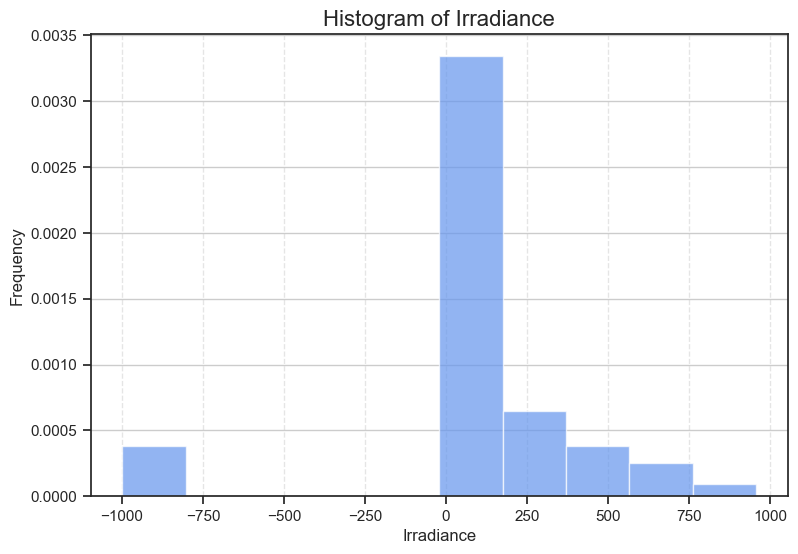

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the histogram
df_zurich['IRRADIANCE'].hist(density=True, alpha=0.7, color='cornflowerblue')

# Set plot title and axis labels
ax.set_title('Histogram of Irradiance', fontsize=16)
ax.set_xlabel('Irradiance')
ax.set_ylabel('Frequency')

# Add vertical grid lines
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Save the plot as a PDF file with higher quality
plt.savefig('/Users/melisa/Documents/IPD/SolarIrradiancePrediction-UZH/zurich_inradiance', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Close the plot to free up memory
plt.close()


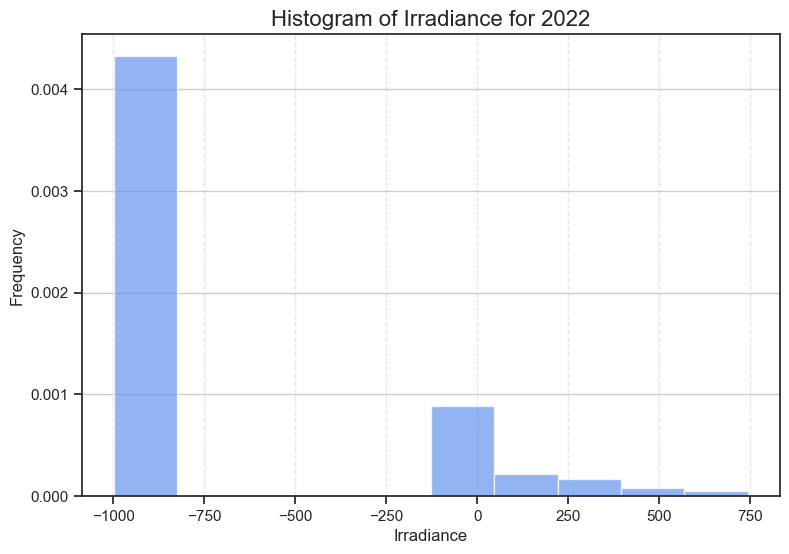

In [ ]:
df_zurich_2021 = df_zurich[df_zurich['YEAR'] == 2022]
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the histogram
df_zurich_2021['IRRADIANCE'].hist(density=True, alpha=0.7, color='cornflowerblue')

# Set plot title and axis labels
ax.set_title('Histogram of Irradiance for 2022', fontsize=16)
ax.set_xlabel('Irradiance')
ax.set_ylabel('Frequency')

# Add vertical grid lines
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Save the plot as a PDF file with higher quality
plt.savefig('/Users/melisa/Documents/IPD/SolarIrradiancePrediction-UZH/images_download', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Close the plot to free up memory
plt.close()

In [87]:
df_zurich = df_zurich.iloc[:78888]
df_dijon = df_dijon.iloc[:78888]
df_milano = df_milano.iloc[:78888]
df_innsbruck = df_innsbruck.iloc[:78888]
df_karlsruhe = df_karlsruhe.iloc[:78888]
dfs = [df_zurich, df_dijon, df_milano, df_innsbruck, df_karlsruhe]
cities = ['Zurich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']

## Missing Values
We check for Missing (Nan) Values and we see that we have none.

In [88]:
for city, df in zip(cities, dfs):
    a = max(df.isna().sum())
    print(f'The amount of rows with NaN values for {city} are: {a} \n')

The amount of rows with NaN values for Zurich are: 0 

The amount of rows with NaN values for Dijon are: 0 

The amount of rows with NaN values for Milano are: 0 

The amount of rows with NaN values for Innsbruck are: 0 

The amount of rows with NaN values for Karlsruhe are: 0 



## Data Augmentation
We use Astral library to add a "Time of Sunrise" and "Time of Sunset" column to each dataset.

In [89]:
zurich = LocationInfo("Zurich", "Switzerland", "Europe", 47.3557, 8.5555)
dijon = LocationInfo("Dijon", "France", "Europe", 47.3273, 5.0591)
milano = LocationInfo("Milan", "Italy", "Europe", 45.4882, 9.2297)
innsbruck = LocationInfo("Innsbruck", "Austria", "Europe", 47.2677, 11.4119)
karlsruhe = LocationInfo("Karlsruhe", "Germany", "Europe", 48.9943, 8.4346)
cities = [zurich, dijon, milano, innsbruck, karlsruhe]

for city, df in zip(cities, dfs):
    time_sunrise, time_sunset = [], []
    for year in range(2013, 2022):
        for month in range(1, 13):
            if month in [11, 4, 6, 9]:
                for day in range(1, 31):
                    time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                    time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
            if month == 2: 
                if year in [2016, 2020]:
                    for day in range(1,30):
                        time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                        time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
                else:
                    for day in range(1,29):
                        time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                        time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
            if month in [1, 3, 5, 7, 8, 10, 12]:
                for day in range(1,32):
                    time_sunrise.append(sun(city.observer, date=datetime.date(year, month, day))["sunrise"])
                    time_sunset.append(sun(city.observer, date=datetime.date(year, month, day))["sunset"])
                    
    sunrise = [x for x in time_sunrise for _ in range(24)]
    sunset = [x for x in time_sunset for _ in range(24)]
    df['SUNRISE'] = sunrise
    df['SUNSET'] = sunset

# Feature Engineering

Transforming the time of sunrise/sunset into ”how much time elapsed after sunrise” (SUNRISE) / ”how much time till sunset” (SUNSET) and "LIGHT", i.e., a binary variable indicating whether the sun is up or not at that specific measurement time. 

In [90]:
dfs = [df_zurich, df_dijon, df_milano, df_innsbruck, df_karlsruhe]
for df in dfs:
  df['TIME'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])
  df["TIME"] = df["TIME"].apply(lambda x: int(x.timestamp()))
  df["SUNRISE"] = df["SUNRISE"].apply(lambda x: int(x.timestamp()))
  df["SUNSET"] = df["SUNSET"].apply(lambda x: int(x.timestamp()))
  df["SUNRISE"] = df["TIME"] - df["SUNRISE"]
  df["SUNSET"] = df["TIME"] - df["SUNSET"]
  df['LIGHT'] = np.where(np.sign(df['SUNRISE']) != np.sign(df['SUNSET']), 1, 0)

Normalization of the following columns:


*   Temperature
*   Humidity
*   Precipitation
*   Pressure
*   Wind Speed
*   Dew
*   Wet Bulb Temperature




In [91]:
cols_to_normalize = ['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'DEW', 'WET BULB TEMPERATURE']
scaler = MinMaxScaler()

# Data Exploration

In [92]:
df_zurich.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   YEAR                  78888 non-null  int64  
 1   MONTH                 78888 non-null  int64  
 2   DAY                   78888 non-null  int64  
 3   HOUR                  78888 non-null  int64  
 4   IRRADIANCE            78888 non-null  float64
 5   TEMPERATURE           78888 non-null  float64
 6   HUMIDITY              78888 non-null  float64
 7   PRECIPITATION         78888 non-null  float64
 8   PRESSURE              78888 non-null  float64
 9   WIND SPEED            78888 non-null  float64
 10  WIND DIRECTION        78888 non-null  float64
 11  DEW                   78888 non-null  float64
 12  WET BULB TEMPERATURE  78888 non-null  float64
 13  SUNRISE               78888 non-null  int64  
 14  SUNSET                78888 non-null  int64  
 15  TIME               

## Split dataset and define ticks

Splitting the datasets for plotting in "Features as functions of time". Define arrays for the X and Y arrays in the plots.  

In [93]:
# Split the zurich dataset in subsets for each year
df_zurich_2013 = df_zurich[df_zurich['YEAR'] == 2013] 
df_zurich_2014 = df_zurich[df_zurich['YEAR'] == 2014] 
df_zurich_2015 = df_zurich[df_zurich['YEAR'] == 2015] 
df_zurich_2016 = df_zurich[df_zurich['YEAR'] == 2016] 
df_zurich_2017 = df_zurich[df_zurich['YEAR'] == 2017] 
df_zurich_2018 = df_zurich[df_zurich['YEAR'] == 2018] 
df_zurich_2019 = df_zurich[df_zurich['YEAR'] == 2019] 
df_zurich_2020 = df_zurich[df_zurich['YEAR'] == 2020] 
df_zurich_2021 = df_zurich[df_zurich['YEAR'] == 2021] 

In [94]:
# Split dataframe into parts for later
df_firsts = df_zurich[df_zurich['DAY'] == 1]
df_firsts_2021 = df_firsts[df_firsts['YEAR']==2021]
df_firsts_midday = df_firsts[df_firsts['HOUR']==12]
df_firsts_midday_2021 = df_firsts_midday[df_firsts_midday['YEAR']==2021]
df_firsts_midday_2013 = df_firsts_midday[df_firsts_midday['YEAR']==2013]

df_startyear = df_firsts_midday[df_firsts_midday['MONTH']==1]

df_junes = df_zurich[df_zurich['MONTH']==6]
df_middyear = df_junes[df_junes['DAY'] == 30]
df_middyear_midday = df_middyear[df_middyear['HOUR']==12]

df_june_15s = df_junes[df_junes['DAY']==15]
df_june_15_2021 = df_june_15s[df_june_15s['YEAR']==2021]

In [95]:
ticks_yearly = df_startyear.index
years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

ticks_months_2021 = df_firsts_midday_2021.index
ticks_all_months = df_firsts_midday_2013.index
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

FEATURES = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']
UNITS = ['[W/m^2]','[°C]','[g/kg]', '[mm/h]', '[kPa]','[m/s]','[°]','[°C]','[°C]']

ti = df_june_15_2021.reset_index(drop=True)
ticks_day = ti.index


## Histogram

Histograms of features and "wind-rose" plot of wind direction.

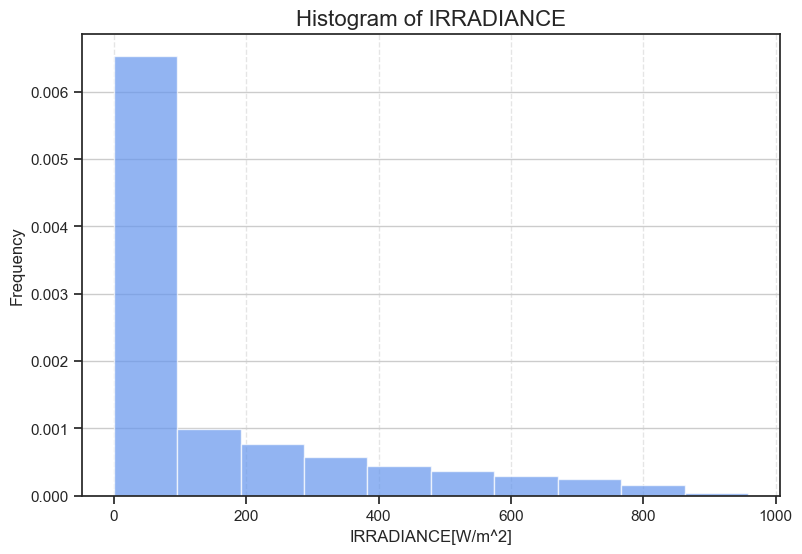

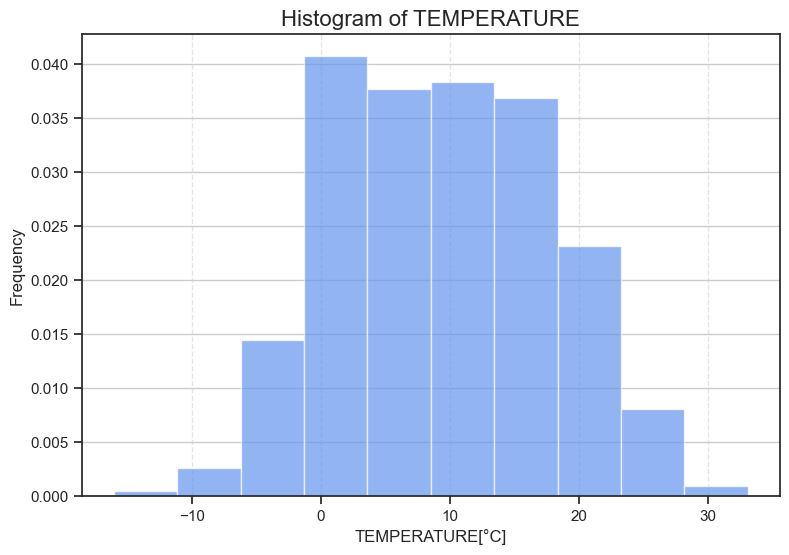

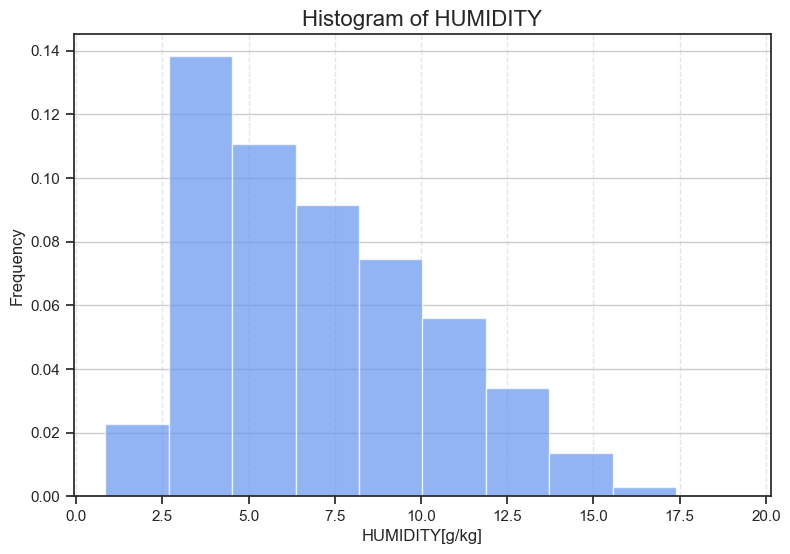

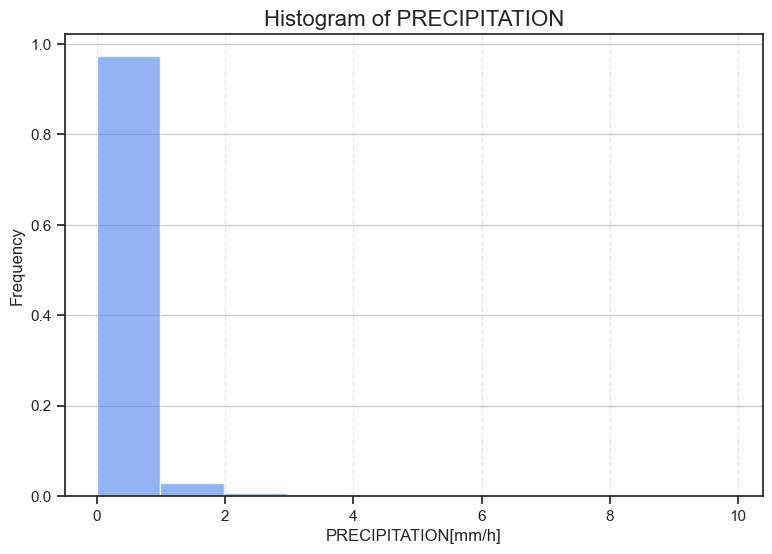

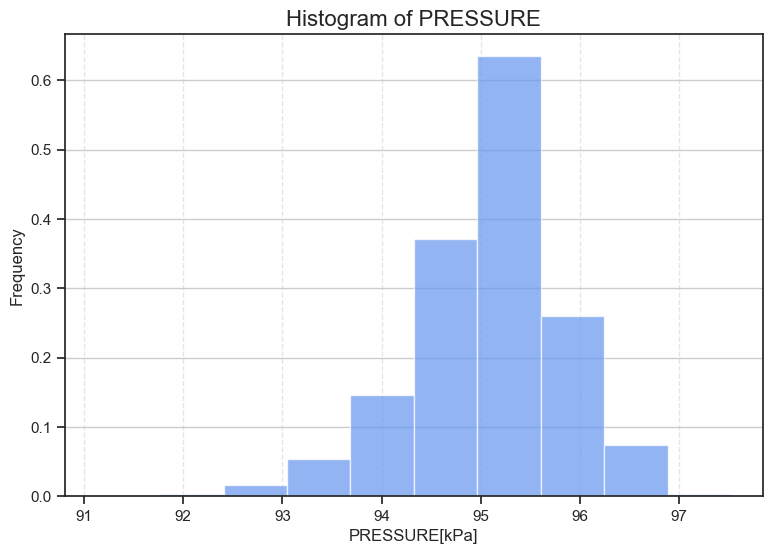

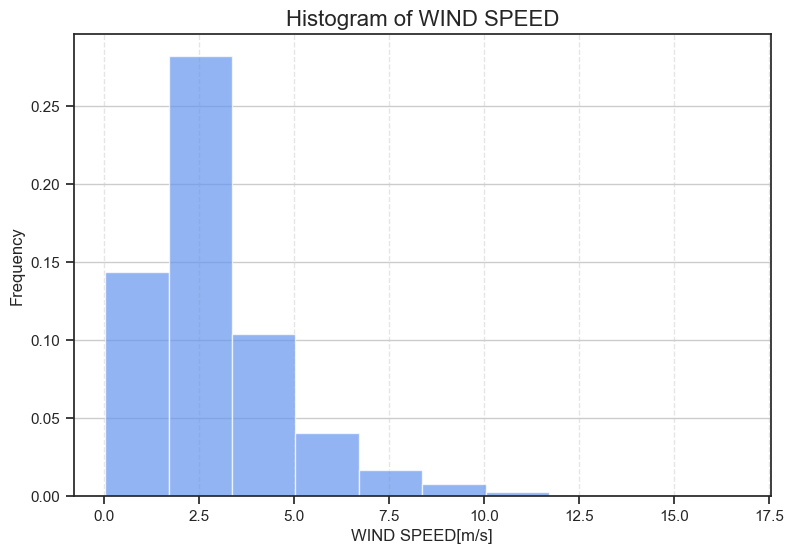

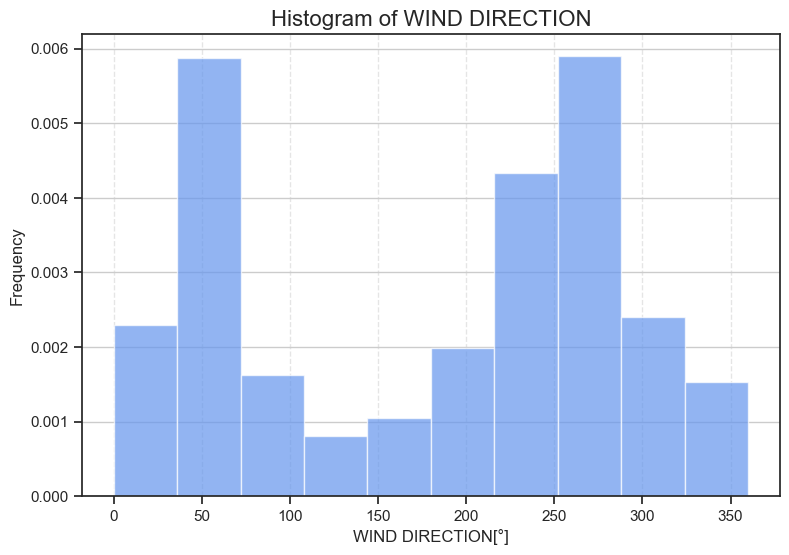

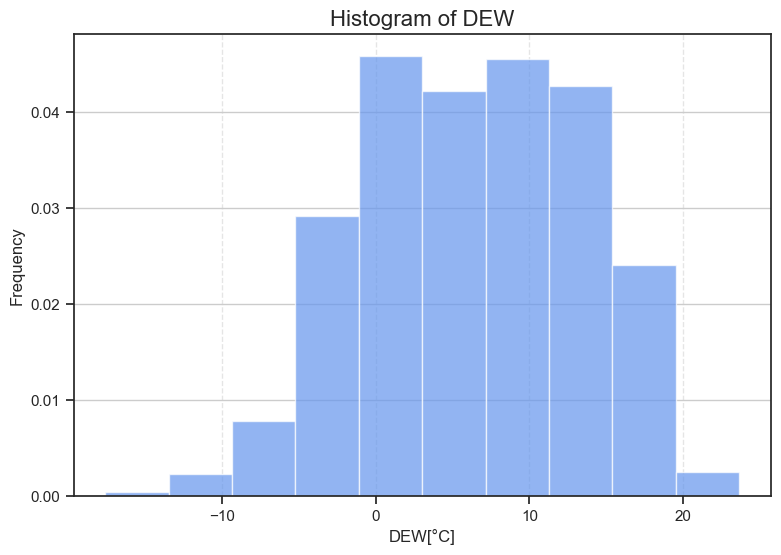

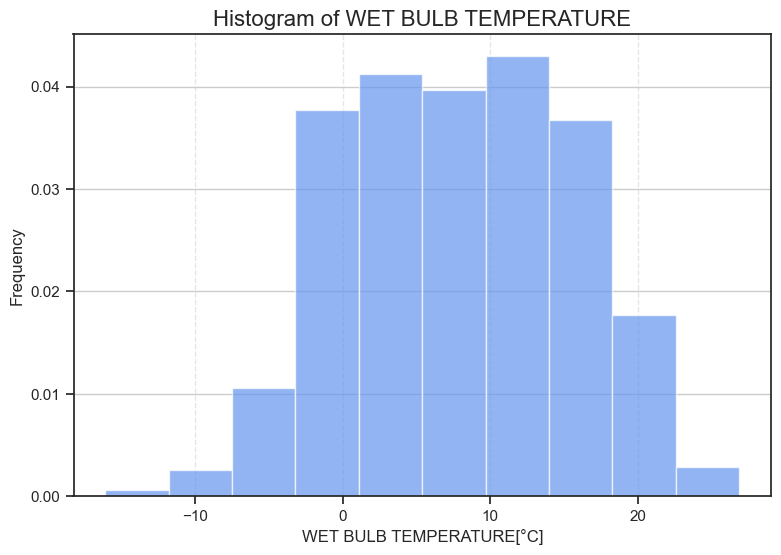

In [ ]:
# Create histograms for each feature
for i, feature in enumerate(FEATURES):
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # Plot the histogram
    df_zurich[feature].hist(density=True, alpha=0.7, color='cornflowerblue')

    # Set plot title and axis labels
    ax.set_title('Histogram of ' + feature, fontsize=16)
    ax.set_xlabel(feature + UNITS[i])
    ax.set_ylabel('Frequency')

    # Add vertical grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    
 

    # show the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

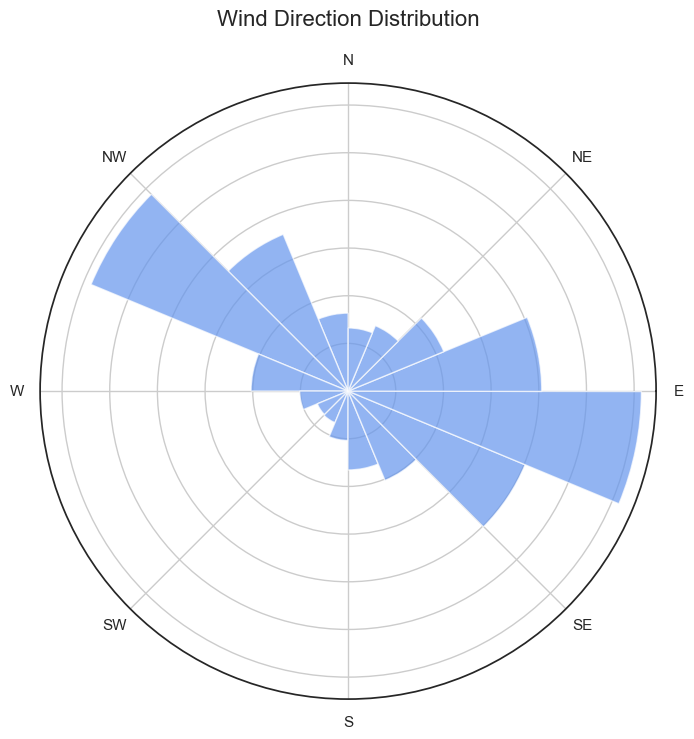

In [97]:
# Convert wind direction to radians
wind_direction_rad = np.deg2rad(df_zurich['WIND DIRECTION']) + np.pi/2

# Set the number of directional bins
num_bins = 16

# Calculate the histogram of wind directions
hist, bins = np.histogram(wind_direction_rad, bins=num_bins)

# Create a polar plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Set the direction labels
directions = ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
ax.set_xticklabels(directions)

# Plot the rose plot
ax.bar(bins[:-1], hist, width=2*np.pi/num_bins, align='edge', color='cornflowerblue', alpha=0.7)

# Set gridlines
ax.grid(True)

# Set plot title
plt.title('Wind Direction Distribution', pad=20, fontsize=16)

# Remove y-axis labels
ax.set_yticklabels([])



# Show the plot
plt.show()


## Map  with locations

Map Visualization of the 5 locations (It doesn't correctly display the map in Jupyter, but it can be seen in the colab notebook linked at the top of this file). 

In [98]:
import folium

# Create a map object centered on Europe
map_center = [48.2082, 16.3738]
map_zoom = 5
my_map = folium.Map(location=map_center, zoom_start=map_zoom)

# Define the locations we want to plot
locations = {
    "Zurich": [47.35, 8.55],
    "Milan": [45.47, 9.18],
    "Karlsruhe": [48.99, 8.43],
    "Dijon": [47.32, 5.06],
    "Innsbruck": [47.27, 11.43],
}

# Add markers for each location to the map
for location_name, location in locations.items():
    folium.Marker(
        location=location,
        tooltip=location_name,
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(my_map)

# Display the map
my_map

## Pairplot and correlation matrix

Pairwise plot, correlation plot and combination of the two.

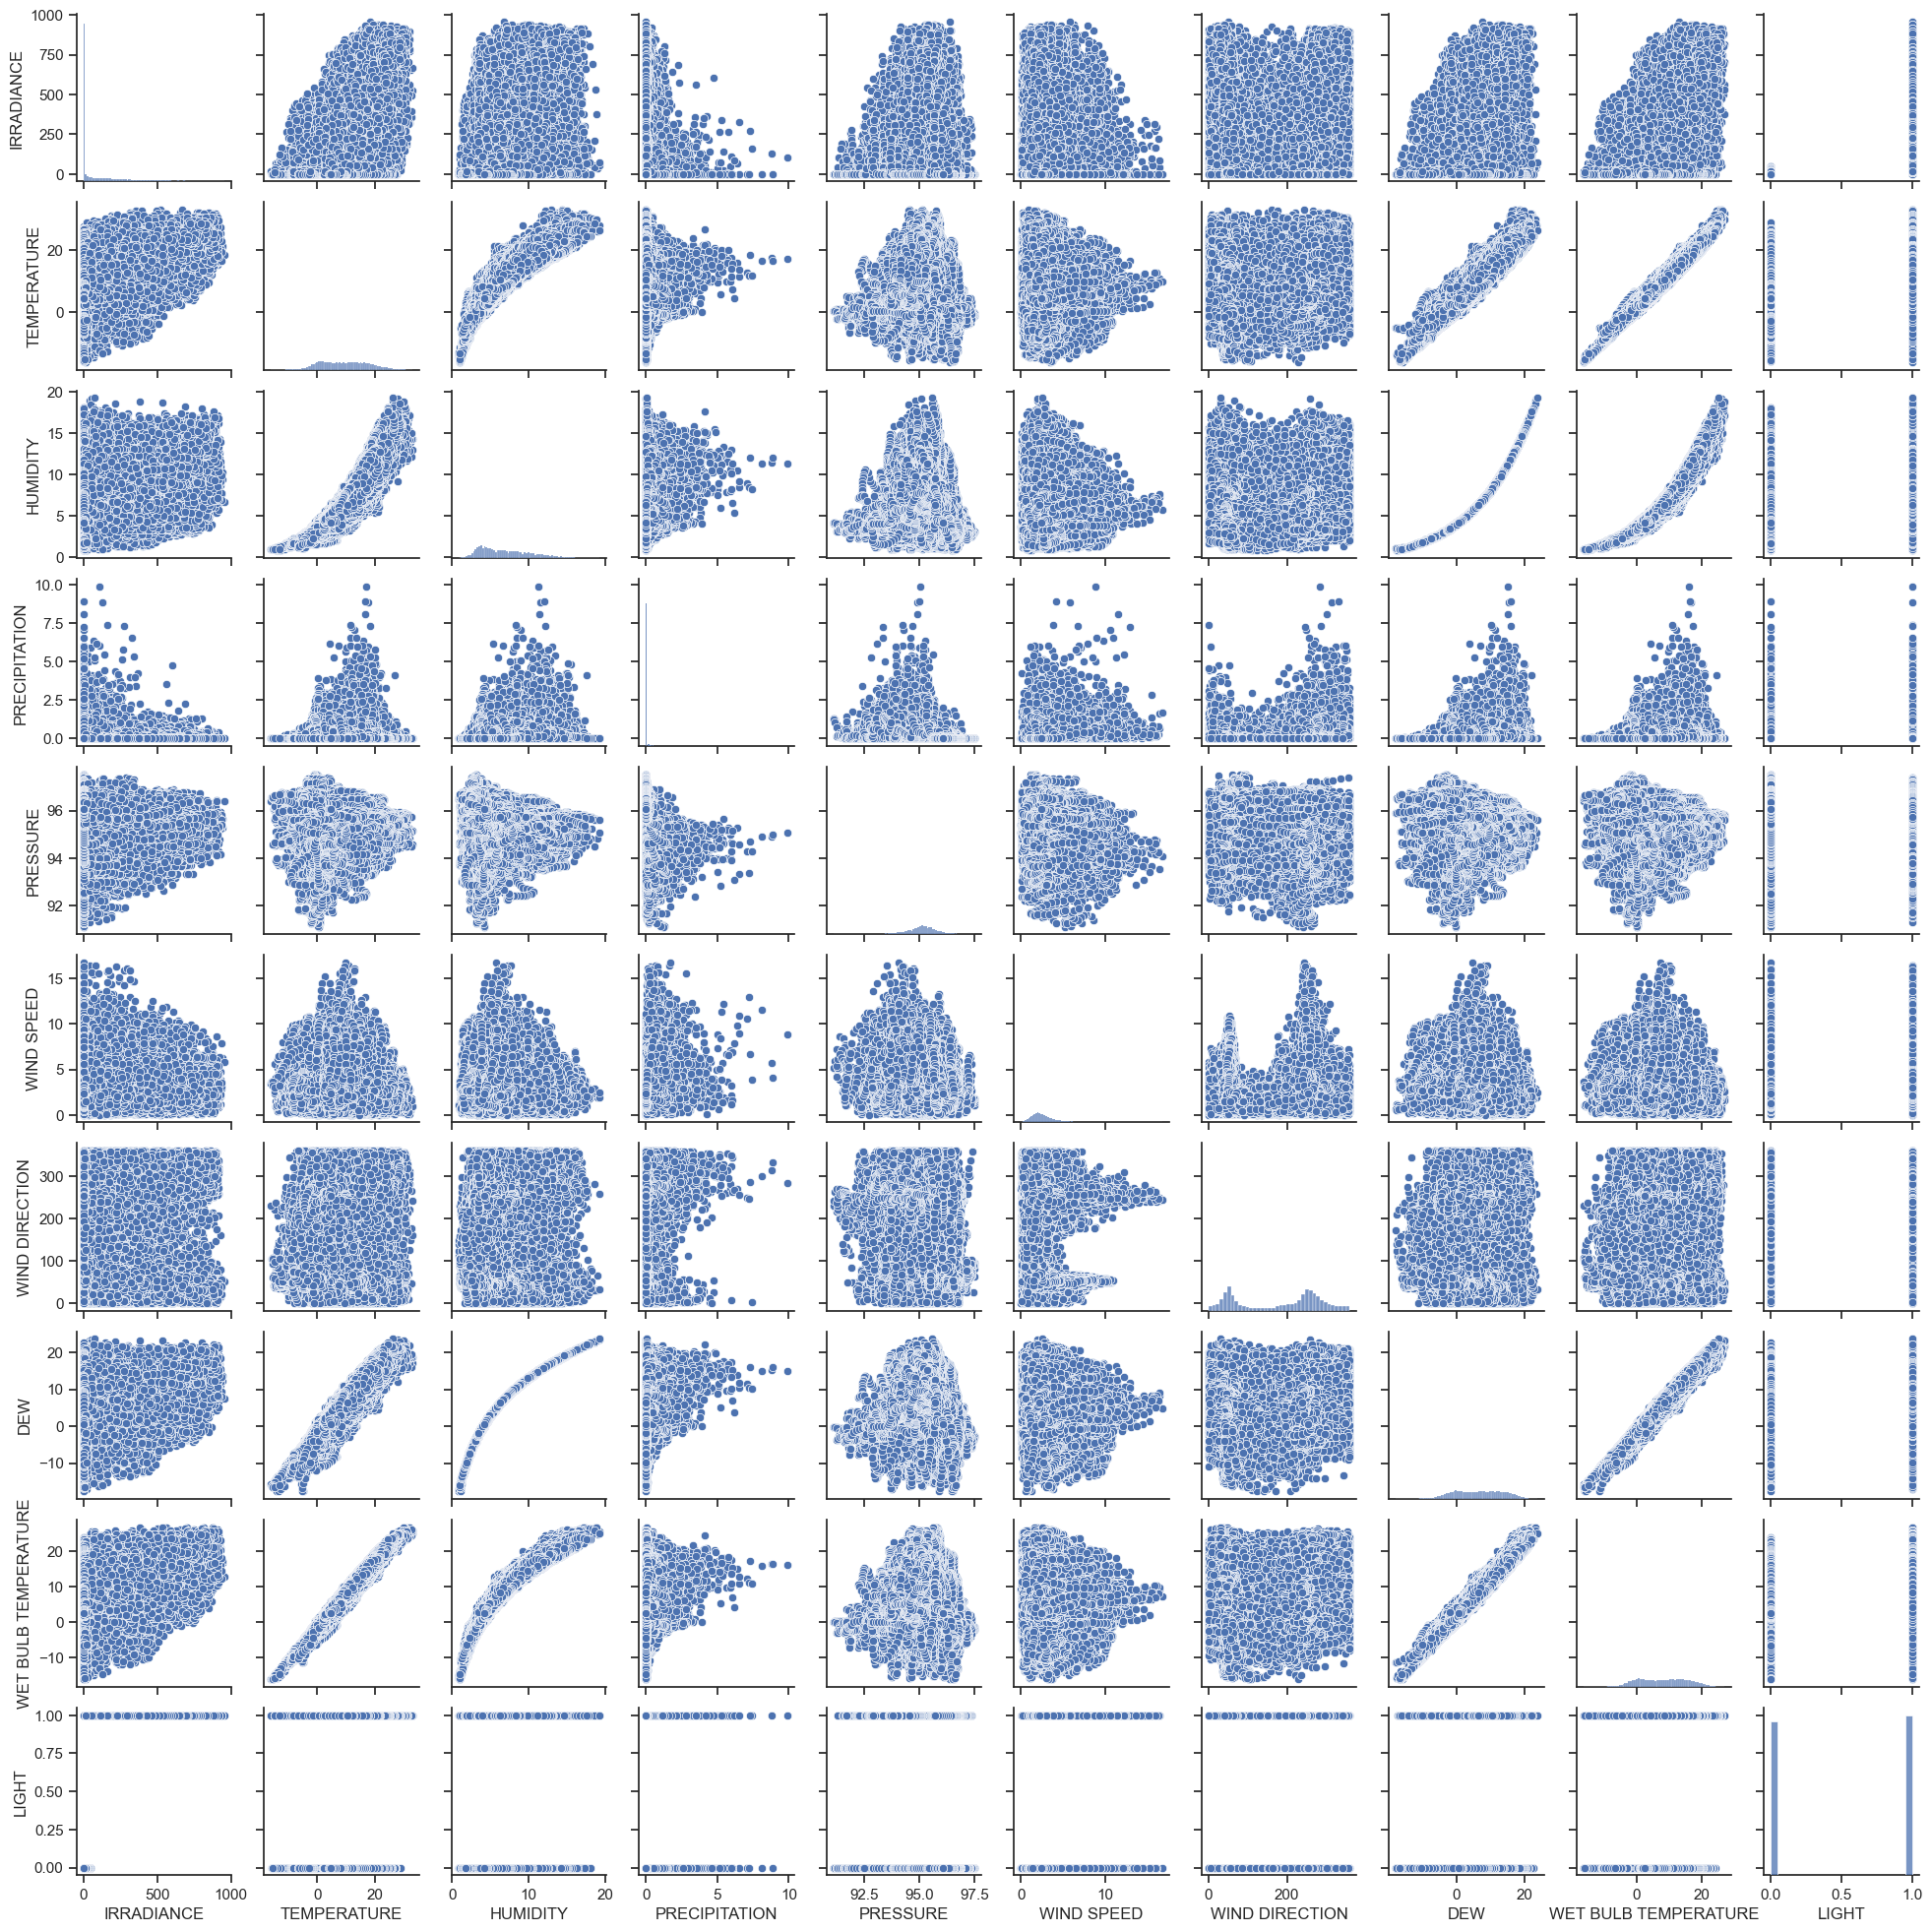

In [99]:
# pairplot for the whole dataset

# Select columns to include in the scatter plot matrix
cols = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE', 'LIGHT']

# Create the scatter plot matrix using seaborn
sns.set(style='ticks')
G = sns.pairplot(df_zurich[cols], diag_kind='hist', height=2)




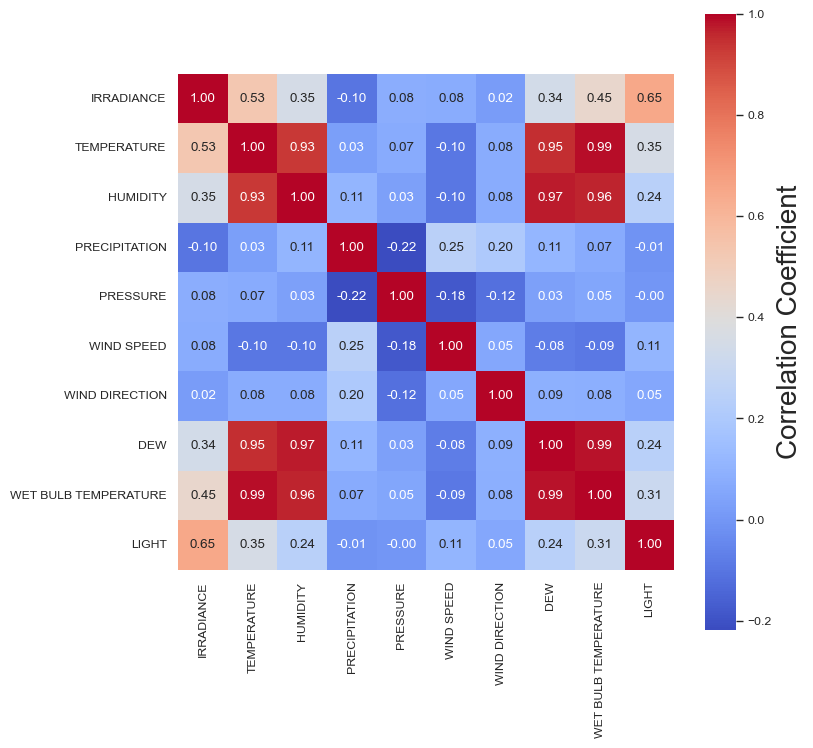

In [100]:
# correlation matrix for the whole dataset (Zurich)
cols = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE', 'LIGHT']
corr = df_zurich[cols].corr()
sns.set(style='white')
sns.set_context("paper", rc={"axes.labelsize":20})
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr, square=True, cmap='coolwarm', annot=True, fmt=".2f",
                     cbar_kws={'label': 'Correlation Coefficient'})


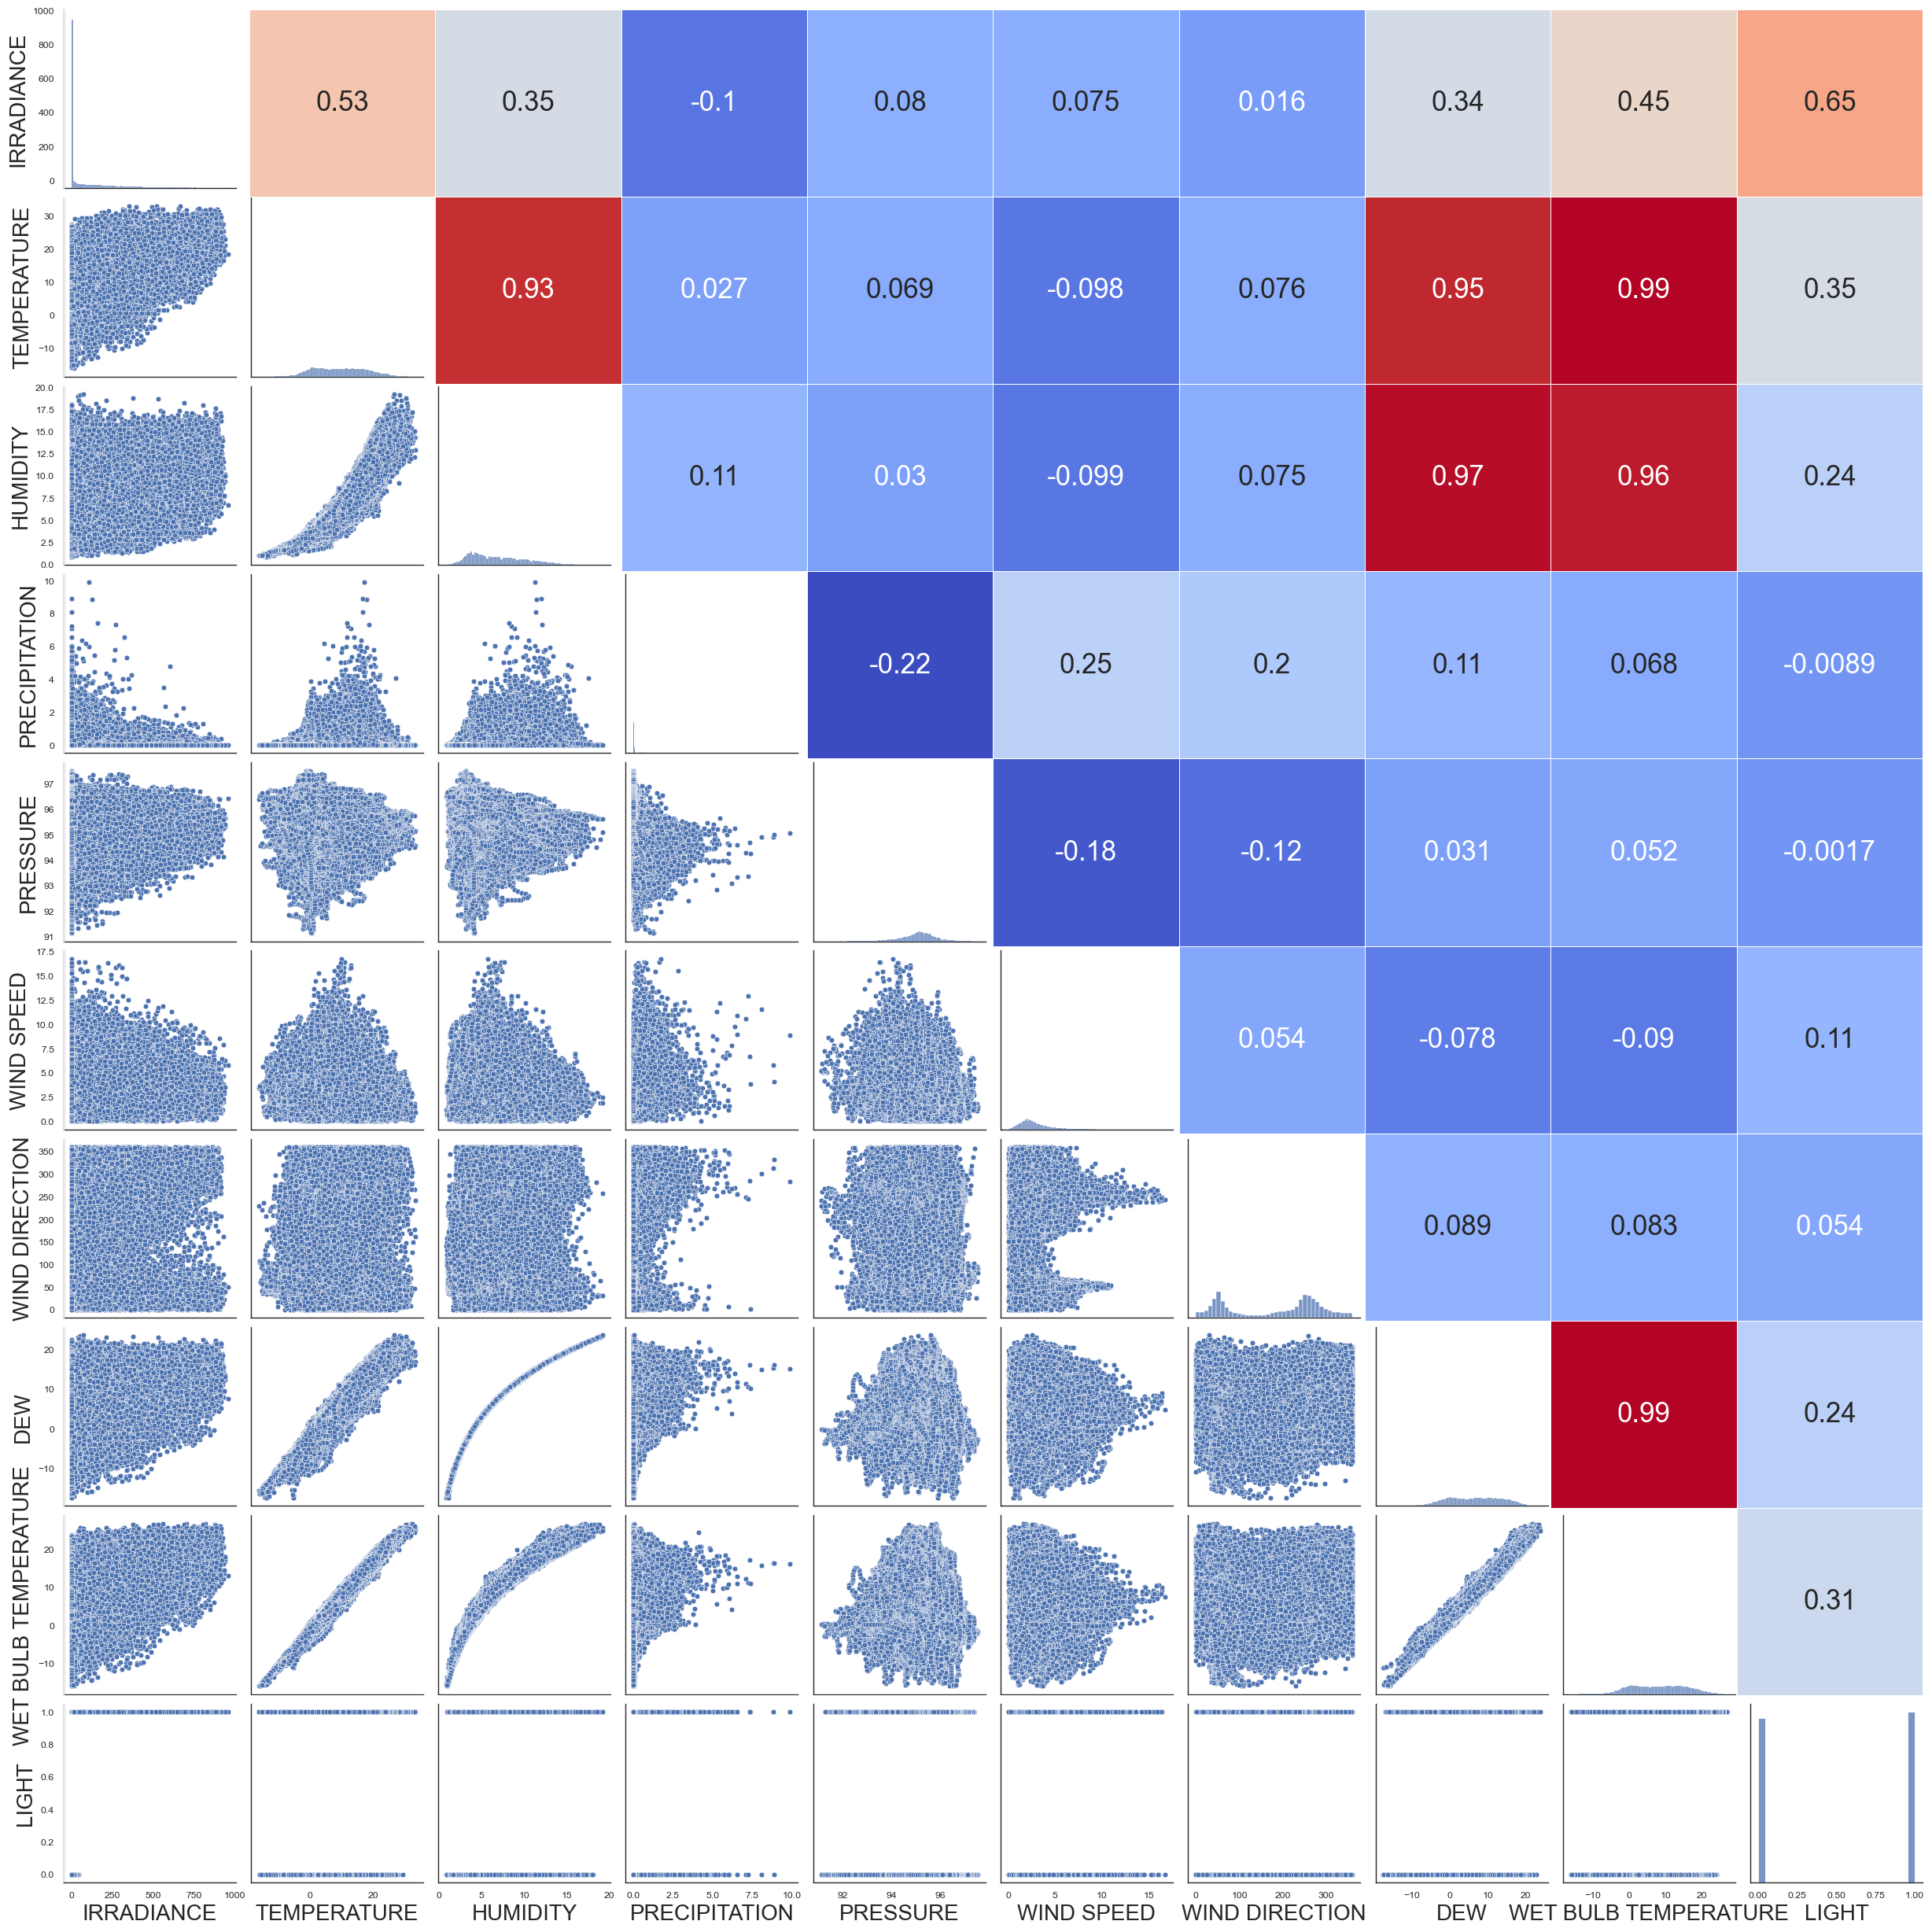

In [101]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

# Select columns to include in the special plot
cols = ['IRRADIANCE', 'TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE', 'LIGHT']
d1 = df_zurich[cols].copy()

sns.set_context("paper", rc={"axes.labelsize":20})
e = sns.pairplot(d1)
e.map_upper(hide_current_axis)

(xmin, _), (_, ymax) = e.axes[0, 0].get_position().get_points()
(_, ymin), (xmax, _) = e.axes[-1, -1].get_position().get_points()

ax = e.fig.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')

corr1 = d1.corr()
mask1 = np.tril(np.ones_like(corr1, dtype=bool))
sns.heatmap(corr1, mask=mask1, cmap='coolwarm', linewidths=.5, cbar=False, annot=True, annot_kws={'size': 25}, ax=ax)


ax.set_xticks([])
ax.set_yticks([])
# ax.xaxis.tick_top()
# ax.yaxis.tick_right()


plt.show()


In [102]:
for city, df in zip(cities, dfs):
    print(f'The correlation of features with target variable for {city} are: \n')
    print(df.corr()["IRRADIANCE"].sort_values(ascending = False))
    print()
    print()

The correlation of features with target variable for LocationInfo(name='Zurich', region='Switzerland', timezone='Europe', latitude=47.3557, longitude=8.5555) are: 

IRRADIANCE              1.000000
LIGHT                   0.647999
TEMPERATURE             0.529656
WET BULB TEMPERATURE    0.447659
HUMIDITY                0.351225
DEW                     0.340066
PRESSURE                0.080217
WIND SPEED              0.075172
HOUR                    0.040638
YEAR                    0.018283
WIND DIRECTION          0.015637
TIME                    0.013382
DAY                     0.010303
SUNRISE                 0.006435
MONTH                  -0.042923
PRECIPITATION          -0.103425
SUNSET                 -0.117200
Name: IRRADIANCE, dtype: float64


The correlation of features with target variable for LocationInfo(name='Dijon', region='France', timezone='Europe', latitude=47.3273, longitude=5.0591) are: 

IRRADIANCE              1.000000
LIGHT                   0.649798
TEMPERATURE   

## Features as a function of time

### Features over all years

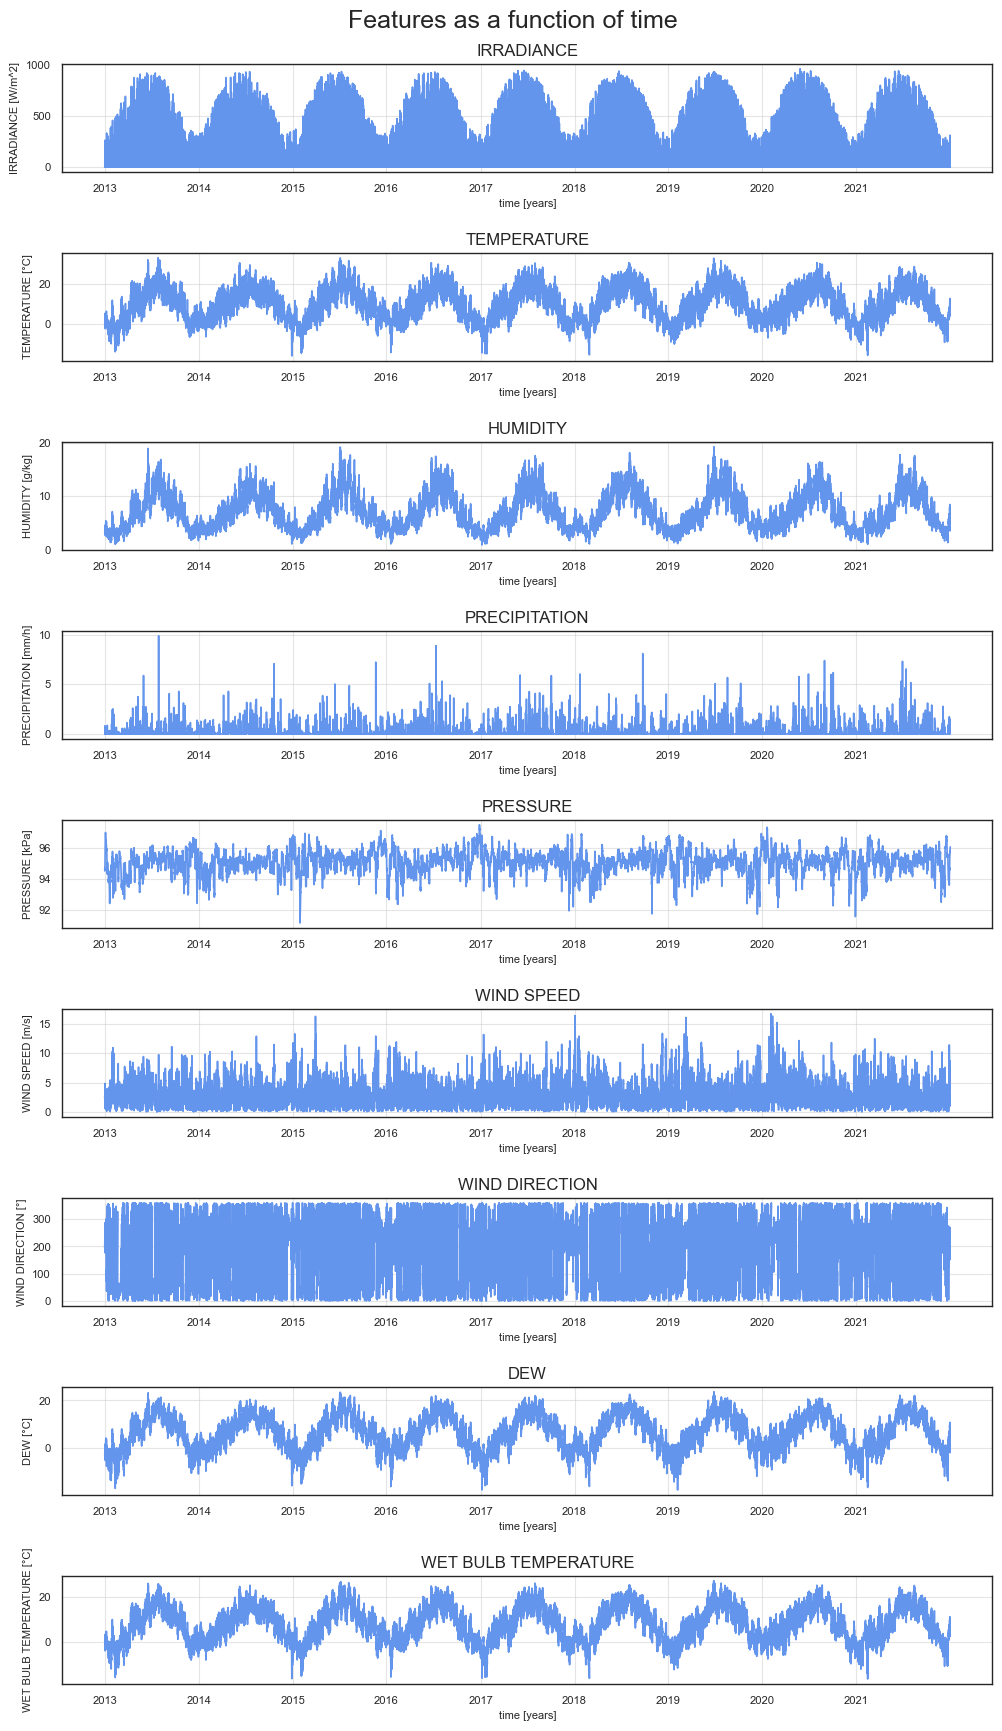

In [103]:
# features as a function of time for all years
# create figure with subplots for each feature
fig, axs = plt.subplots(nrows=9, figsize=(12, 18))
fig.suptitle('Features as a function of time', fontsize=18)

# loop over each feature and create a subplot
for i, feature in enumerate(FEATURES):
    axs[i].plot(df_zurich[feature], color='cornflowerblue')
    axs[i].set_title(feature, fontsize=12)
    axs[i].set_ylabel(feature + ' ' + UNITS[i],fontsize=8)
    axs[i].set_xticks(ticks_yearly)
    axs[i].set_xticklabels(years, fontsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].grid(True, alpha=0.5)
    axs[i].set_xlabel('time [years]',fontsize=8)


# adjust spacing between subplots
fig.subplots_adjust(hspace=0.75, top=0.95, bottom=0.05)



# show the figure


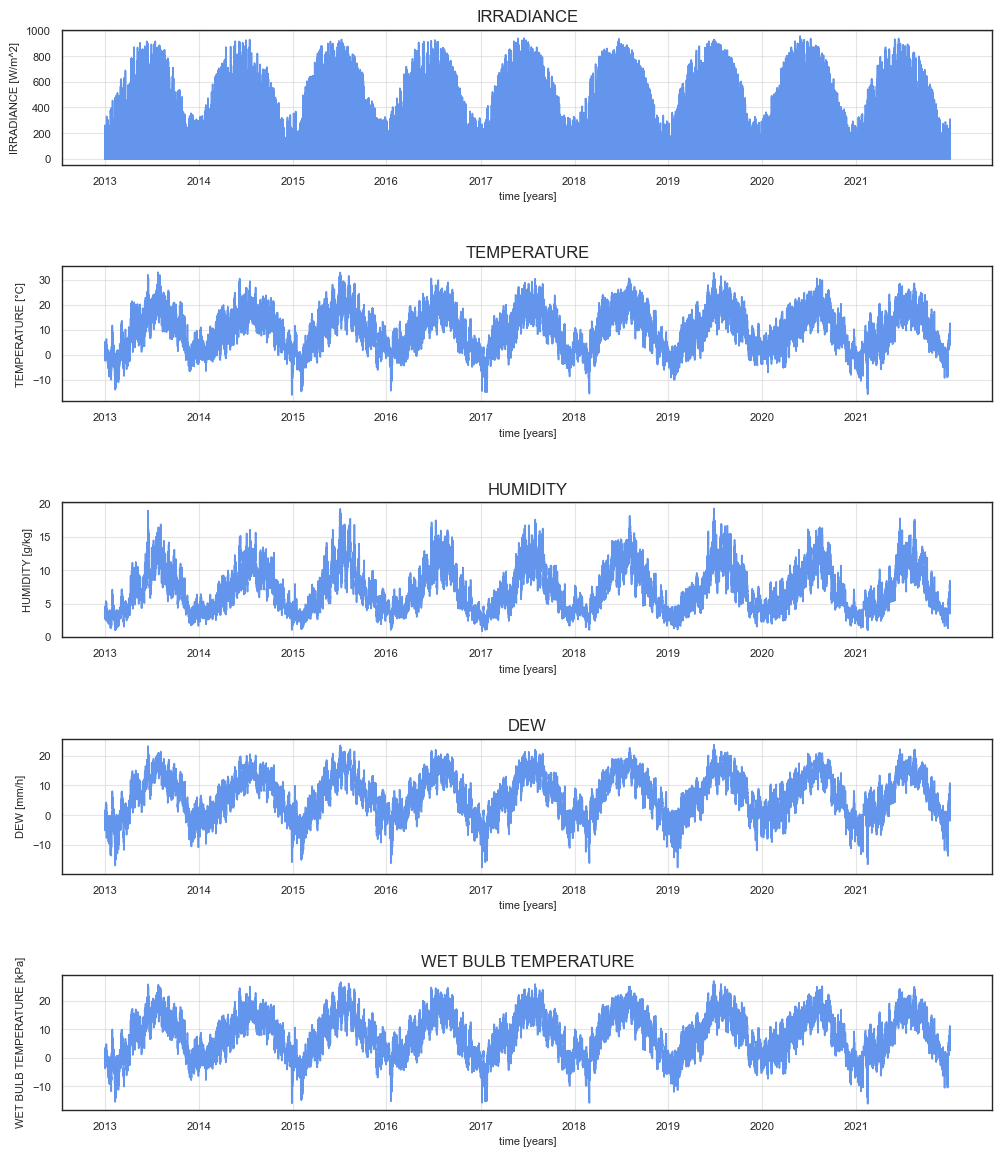

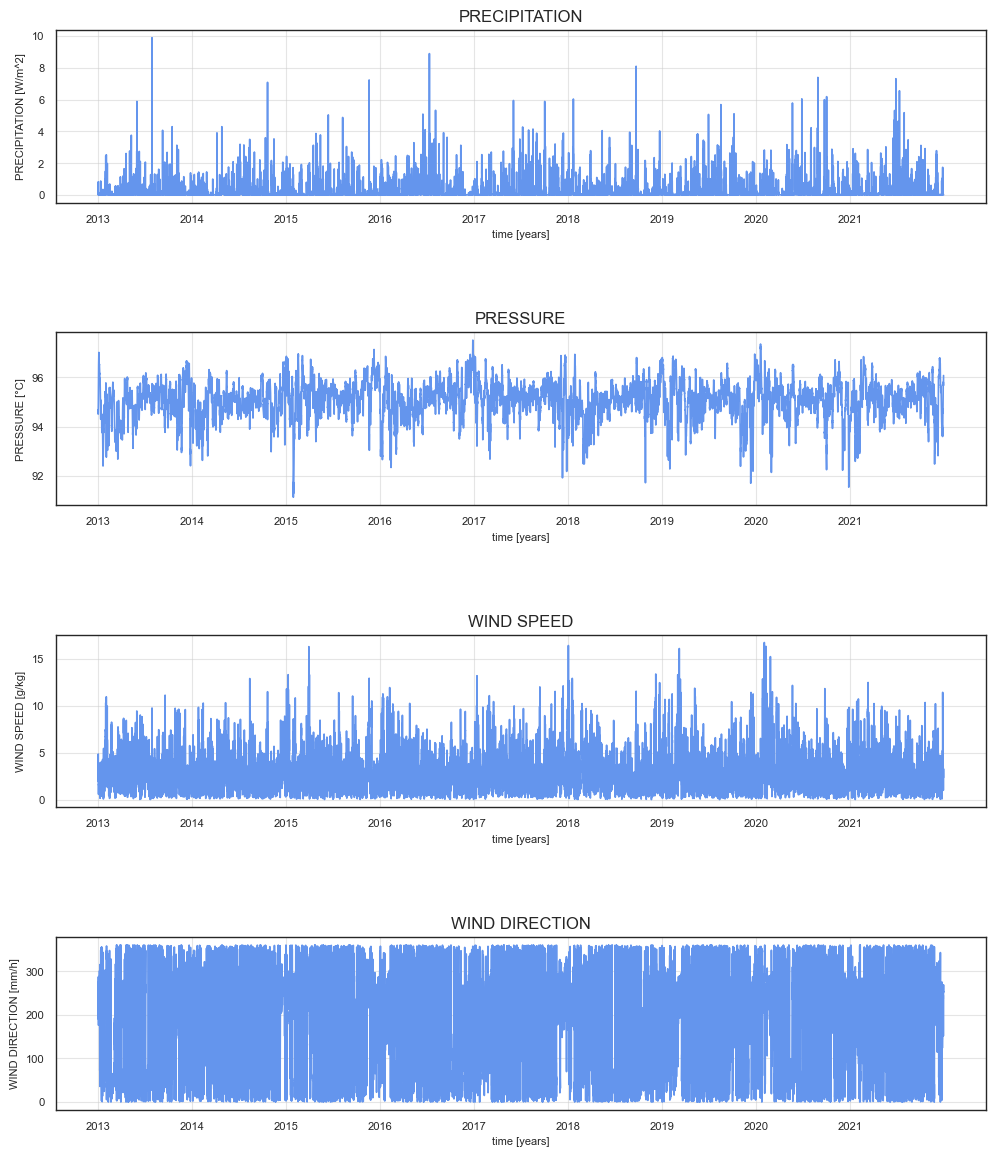

In [104]:
# features as a function of time for all years
# split into two plots
fig1, axs = plt.subplots(nrows=5, figsize=(12, 12))
#fig1.suptitle('Features as a function of time 1', fontsize=18)

# loop over the corresponding features:
for i, feature in enumerate(['IRRADIANCE','TEMPERATURE', 'HUMIDITY','DEW', 'WET BULB TEMPERATURE']):
    axs[i].plot(df_zurich[feature], color='cornflowerblue')
    axs[i].set_title(feature, fontsize=12)
    axs[i].set_ylabel(feature + ' ' + UNITS[i],fontsize=8)
    axs[i].set_xticks(ticks_yearly)
    axs[i].set_xticklabels(years, fontsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].grid(True, alpha=0.5)
    axs[i].set_xlabel('time [years]',fontsize=8)


# adjust spacing between subplots
fig1.subplots_adjust(hspace=0.75, top=0.95, bottom=0.05)

# save the figure
fig1.savefig('features_over_all_time_1.jpeg')
fig1.savefig('features_over_all_time_1.pdf')


# for the oher part of the plot
fig2, axs = plt.subplots(nrows=4, figsize=(12, 12))
#fig2.suptitle('Features as a function of time 2', fontsize=18)

# loop over the corresponding features:
for i, feature in enumerate(['PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION']):
    axs[i].plot(df_zurich[feature], color='cornflowerblue')
    axs[i].set_title(feature, fontsize=12)
    axs[i].set_ylabel(feature + ' ' + UNITS[i],fontsize=8)
    axs[i].set_xticks(ticks_yearly)
    axs[i].set_xticklabels(years, fontsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].grid(True, alpha=0.5)
    axs[i].set_xlabel('time [years]',fontsize=8)


# adjust spacing between subplots
fig2.subplots_adjust(hspace=0.75, top=0.95, bottom=0.05)



### Features over a year

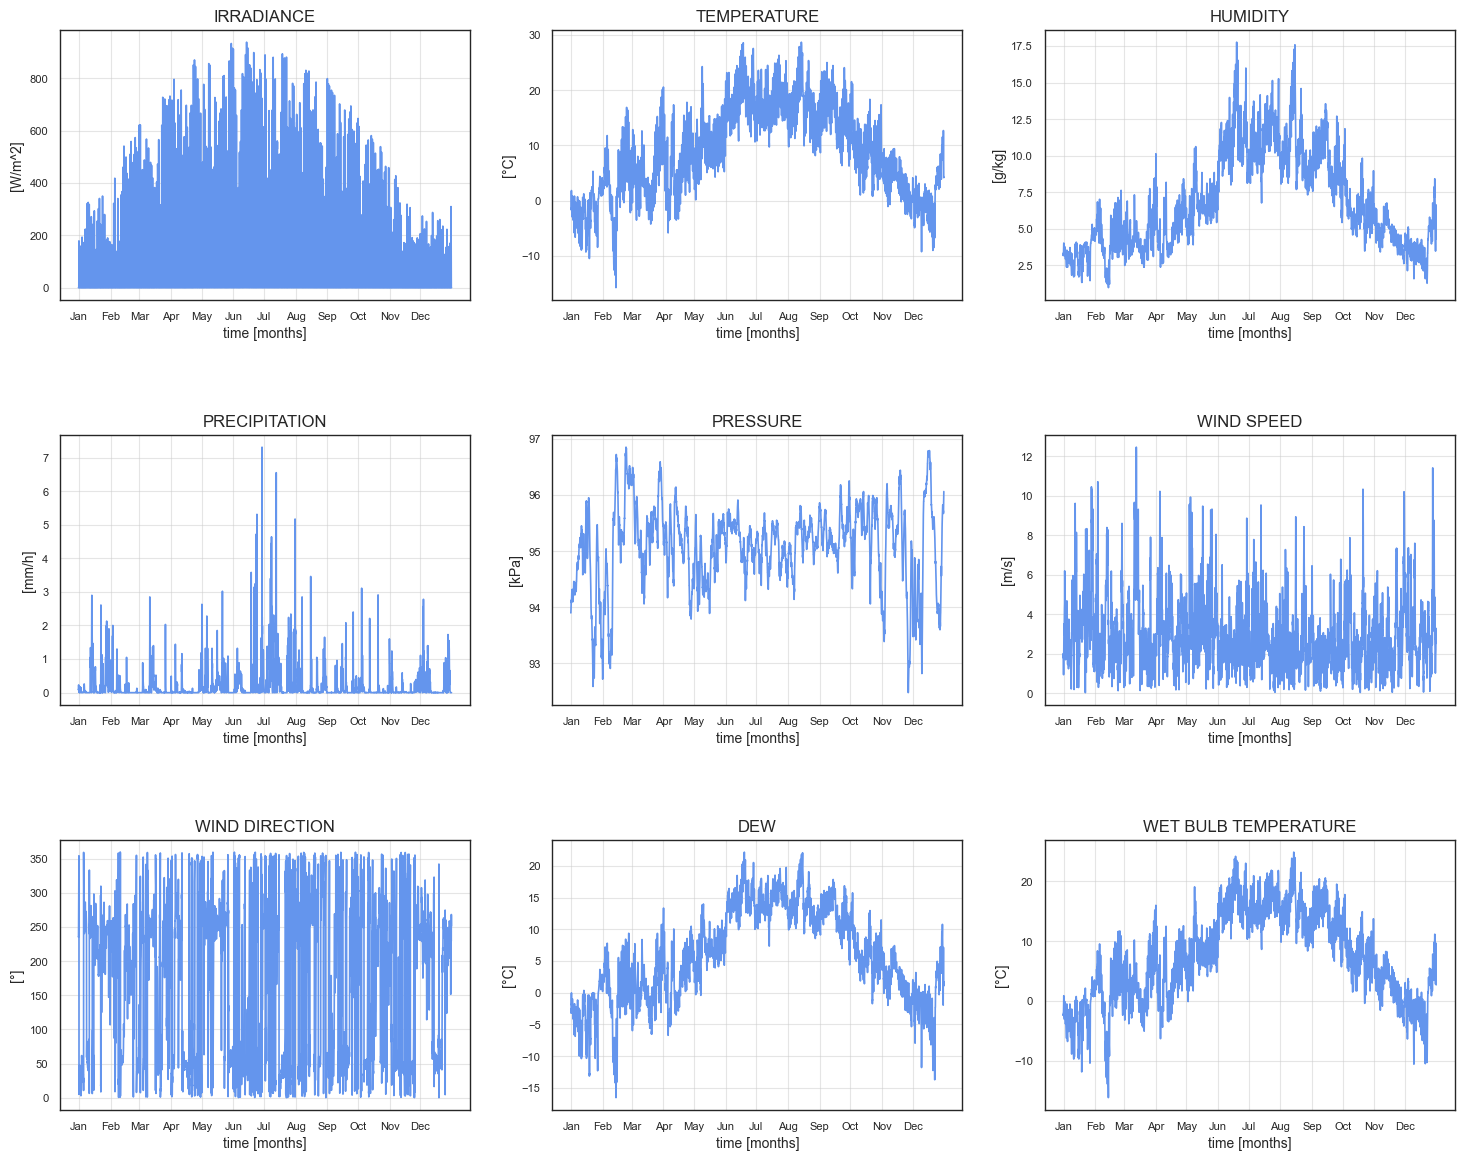

In [105]:
#  features as a function of time for the year 2021
# create figure with subplots for each feature

fig = plt.figure(figsize=(18, 12))

# loop over each feature and create a subplot
for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)
    axs.plot(df_zurich_2021[feature], color='cornflowerblue')
    axs.set_title(feature, fontsize=12)
    axs.set_xlabel('time [months]', fontsize=10)
    axs.set_ylabel(UNITS[i], fontsize=10)
    axs.set_xticks(ticks_months_2021)
    axs.set_xticklabels(months, fontsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.grid(True, alpha=0.5)


# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05)


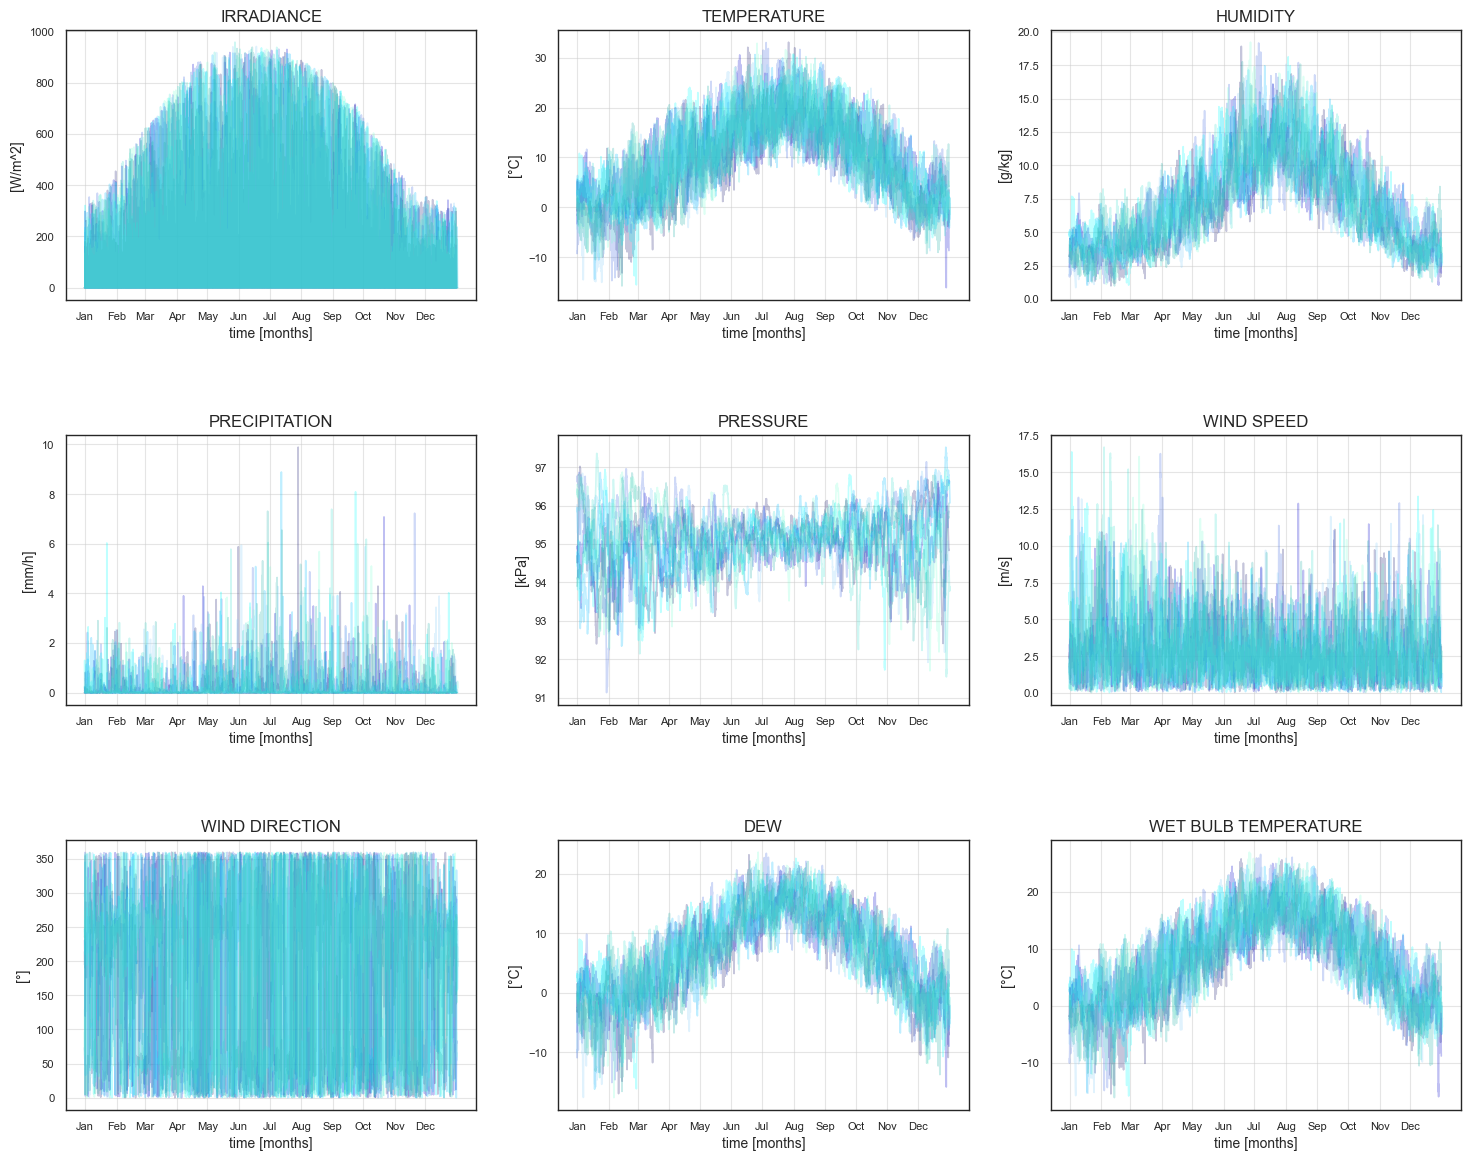

In [106]:
#  features as a function of time for all years
# create figure with subplots for each feature

fig = plt.figure(figsize=(18, 12))

# loop over each feature and create a subplot
for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)

    axs.plot(df_zurich_2013[feature].reset_index(drop=True), color='midnightblue', label='2013',alpha=0.25)
    axs.plot(df_zurich_2014[feature].reset_index(drop=True), color='mediumblue', label='2014',alpha=0.25)
    axs.plot(df_zurich_2015[feature].reset_index(drop=True), color='royalblue', label='2015',alpha=0.25)
    axs.plot(df_zurich_2016[feature].reset_index(drop=True), color='deepskyblue', label='2016',alpha=0.25)
    axs.plot(df_zurich_2017[feature].reset_index(drop=True), color='lightskyblue', label='2017',alpha=0.25)
    axs.plot(df_zurich_2018[feature].reset_index(drop=True), color='aqua', label='2018',alpha=0.25)
    axs.plot(df_zurich_2019[feature].reset_index(drop=True), color='aquamarine', label='2019',alpha=0.25)
    axs.plot(df_zurich_2020[feature].reset_index(drop=True), color='turquoise', label='2020',alpha=0.25)
    axs.plot(df_zurich_2021[feature].reset_index(drop=True), color='lightseagreen', label='2021',alpha=0.25)
    #axs.legend(loc='best')

    axs.set_title(feature, fontsize=12)
    axs.set_xlabel('time [months]', fontsize=10)
    axs.set_ylabel(UNITS[i], fontsize=10)
    axs.set_xticks(ticks_all_months)
    axs.set_xticklabels(months, fontsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.grid(True, alpha=0.5)


# adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05)


### Features over a day as hourly average of the month



In [107]:
# Calculate the mean for each hour over each month for  zurich for each feature
mean_values = [[],[],[],[],[],[],[],[],[],[], []]

# Calculate the standard deviation for each hour over each month for  zurich for each feature
stds = [[],[],[],[],[],[],[],[],[],[], []]

for m in range(12):
    # take data from month
    df_current_month = df_zurich[df_zurich['MONTH']==(m+1)]
    
    # loop over the times
    for hour in range(24):
    
        # make a df for the current hour --> gives us all measurements for this time in this month
        df_current_hour = df_current_month[df_current_month['HOUR'] == hour]
    
        mean_values[9].append(m+1)
        mean_values[10].append(hour)
        stds[9].append(m+1)
        stds[10].append(hour)

    
        # loop over the features
        for i, feature in enumerate(FEATURES):
            # calculate the mean of the feature
            mean = np.mean(df_current_hour[feature])
            # calculate the standard deviation of the feature
            std = np.std(df_current_hour[feature])
            # append the mean to the corresponding feature
            mean_values[i].append(mean)
            stds[i].append(std)

# create a dataframe from the mean values
prepared_df2 = {'IRRADIANCE':mean_values[0],
                'TEMPERATURE':mean_values[1],
                'HUMIDITY':mean_values[2],
                'PRECIPITATION':mean_values[3],
                'PRESSURE':mean_values[4],
                'WIND SPEED':mean_values[5],
                'WIND DIRECTION':mean_values[6],    
                'DEW':mean_values[7],
                'WET BULB TEMPERATURE':mean_values[8],
                'MONTH': mean_values[9],
                'HOUR': mean_values[10]}

df_hour_mean_values_zurich = pd.DataFrame(prepared_df2)

# create a dataframe from the standard deviations
prepared_df3 = {'IRRADIANCE':stds[0],
                'TEMPERATURE':stds[1],
                'HUMIDITY':stds[2],
                'PRECIPITATION':stds[3],
                'PRESSURE':stds[4],
                'WIND SPEED':stds[5],
                'WIND DIRECTION':stds[6],
                'DEW':stds[7],
                'WET BULB TEMPERATURE':stds[8],
                'MONTH': stds[9],
                'HOUR': stds[10]}

df_hour_stds_zurich = pd.DataFrame(prepared_df3)
df_hour_stds_zurich.head()

IRRADIANCE  TEMPERATURE  HUMIDITY  PRECIPITATION  PRESSURE  WIND SPEED  \
0         0.0     4.190989  1.077952       0.432934  1.040963    2.186542   
1         0.0     4.217627  1.082793       0.440613  1.037341    2.213142   
2         0.0     4.247478  1.086925       0.406697  1.035067    2.233965   
3         0.0     4.264104  1.082445       0.361180  1.031915    2.184581   
4         0.0     4.261032  1.078232       0.347898  1.026849    2.112377   

   WIND DIRECTION       DEW  WET BULB TEMPERATURE  MONTH  HOUR  
0       86.049404  4.293277              4.169723      1     0  
1       85.952125  4.368639              4.216874      1     1  
2       85.538886  4.433571              4.260922      1     2  
3       85.577506  4.481321              4.286744      1     3  
4       84.656945  4.513520              4.295328      1     4

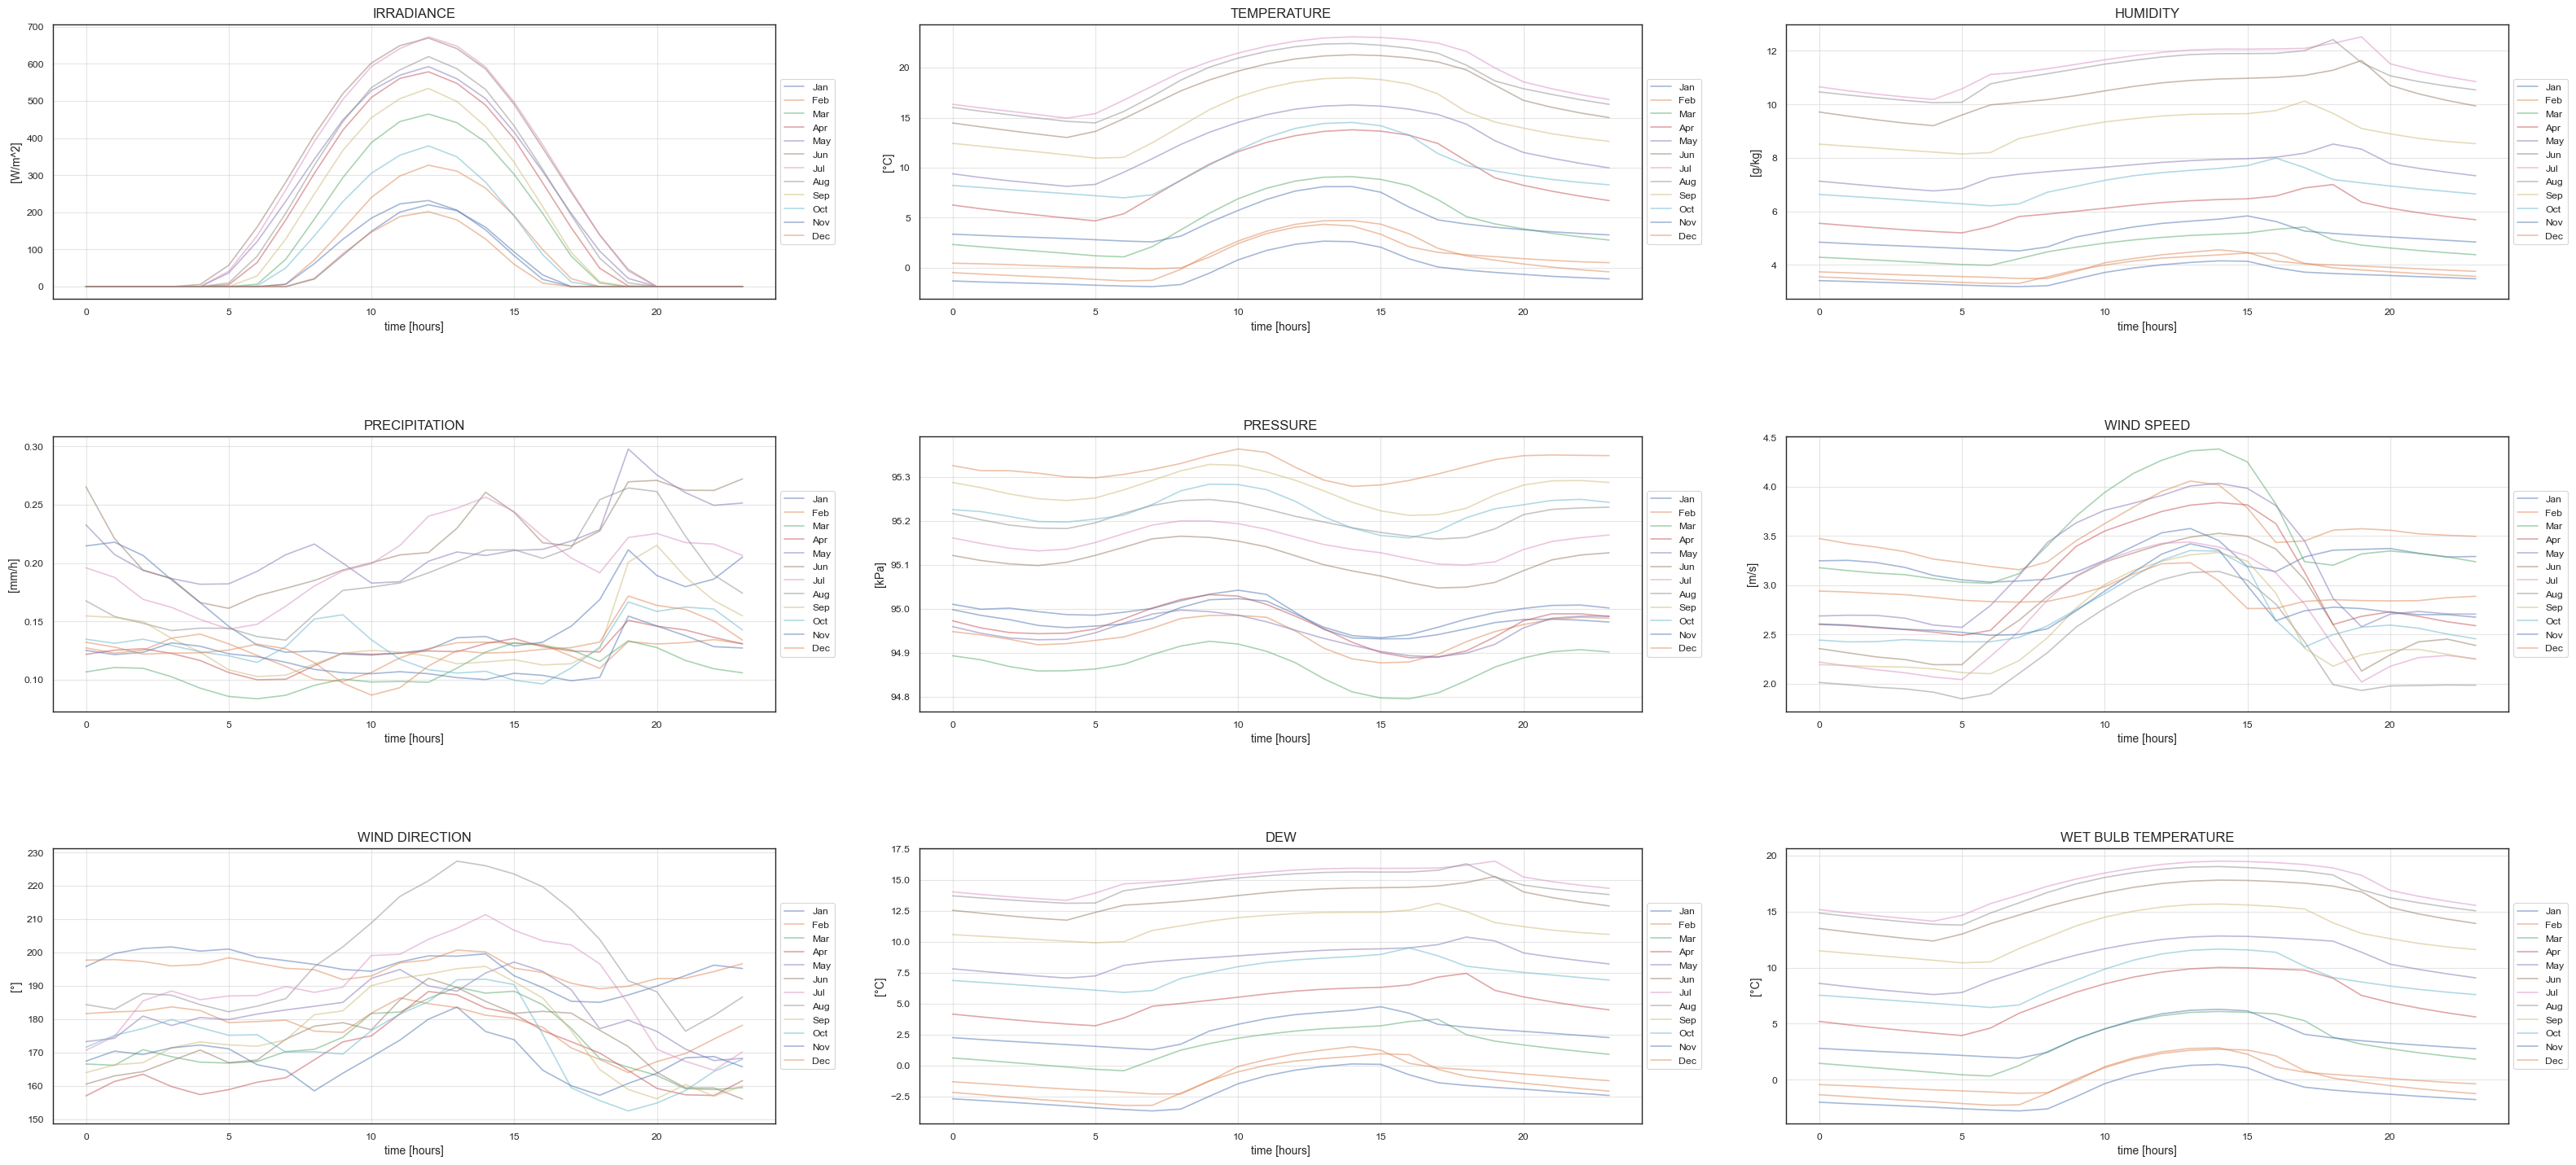

In [108]:
# Plot the mean values
fig = plt.figure(figsize=(18, 15))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# loop over each feature and create a subplot
for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)

    # draw the plot for the feature for each month:
    for m in range(12):
        current_month = df_hour_mean_values_zurich[df_hour_mean_values_zurich['MONTH']==(m+1)]
        axs.plot(current_month[feature].reset_index(drop=True), label=months[m], alpha=0.5)

    axs.set_title(feature, fontsize=12)
    # make legend outside of plot
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # axs.legend(loc='best')
    axs.set_xlabel('time [hours]', fontsize=10)
    axs.set_ylabel(UNITS[i], fontsize=10)
    #axs.tick_params(axis='y', labelsize=8)
    axs.grid(True, alpha=0.5)


# set space between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05, right=1.8)




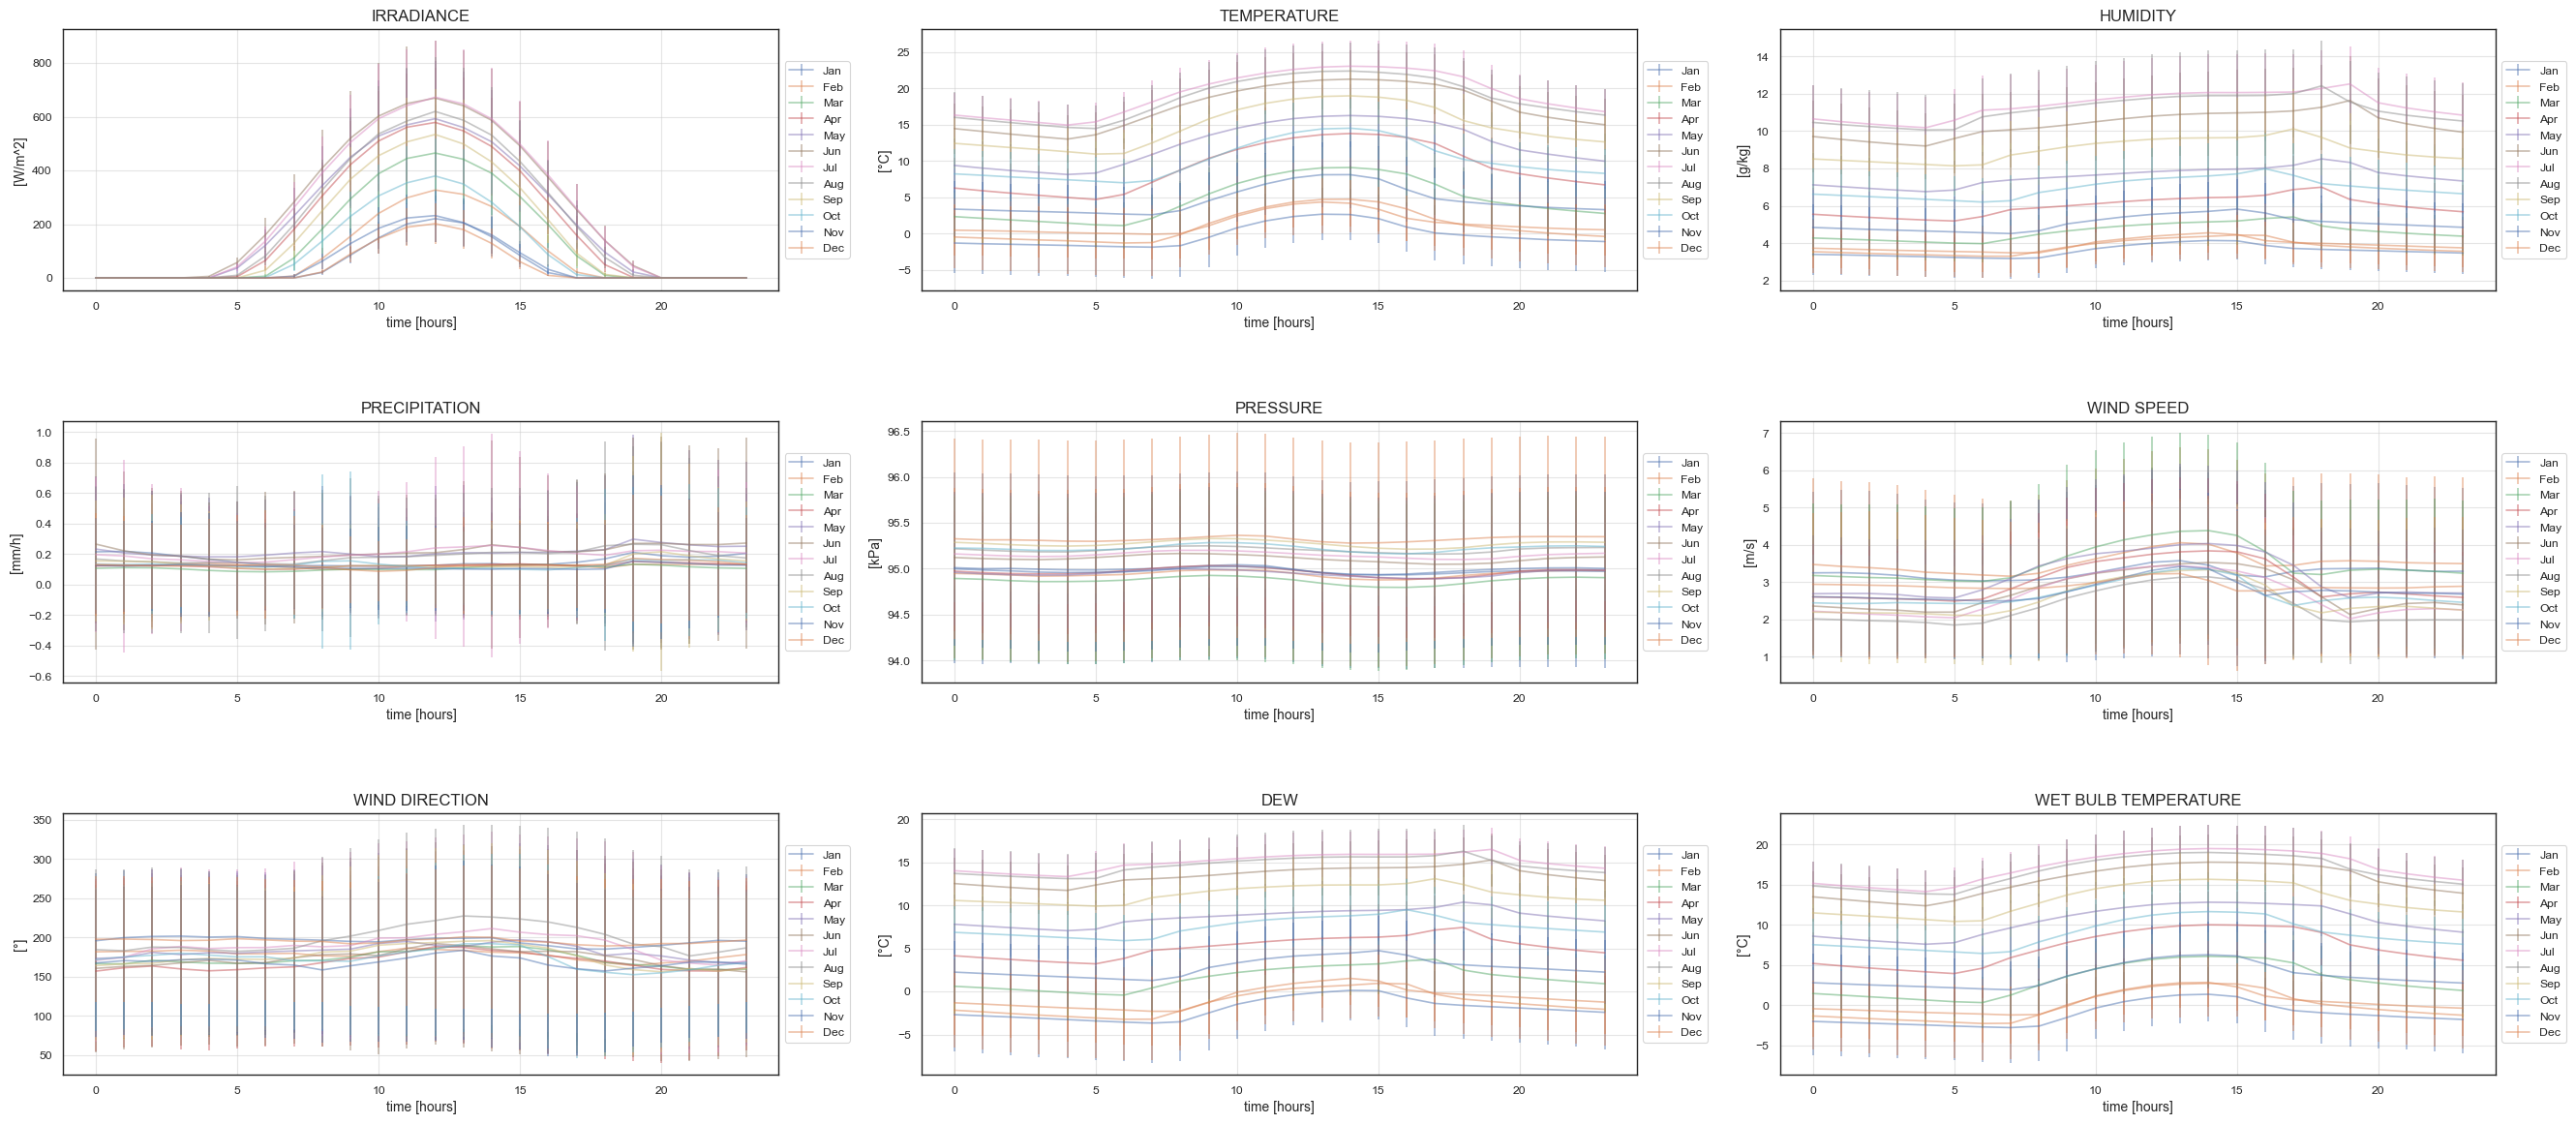

In [109]:
# Plot the mean values and stds
fig = plt.figure(figsize=(15, 12))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# loop over each feature and create a subplot
for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    axs = fig.add_subplot(3, 3, i+1)

    # draw the plot for the feature for each month:
    for m in range(12):
        current_month = df_hour_mean_values_zurich[df_hour_mean_values_zurich['MONTH']==(m+1)]
        current_month_std = df_hour_stds_zurich[df_hour_stds_zurich['MONTH']==(m+1)]
        axs.errorbar(current_month['HOUR'], current_month[feature].reset_index(drop=True), yerr=current_month_std[feature].reset_index(drop=True), label=months[m], alpha=0.5)

    axs.set_title(feature, fontsize=12)
    # make legend outside of plot
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # axs.legend(loc='best')
    axs.set_xlabel('time [hours]', fontsize=10)
    axs.set_ylabel(UNITS[i], fontsize=10)
    #axs.tick_params(axis='y', labelsize=8)
    axs.grid(True, alpha=0.5)


# set space between subplots
fig.subplots_adjust(hspace=0.5, top=0.95, bottom=0.05, right=1.8)





## Plot of the MSE

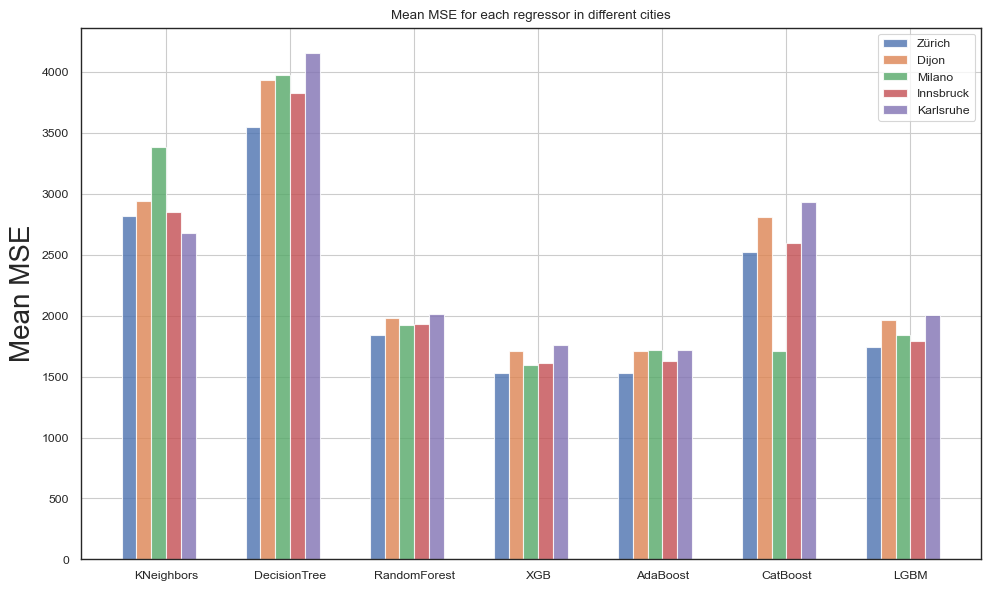

In [ ]:
# Data
regressors = ['KNeighbors', 'DecisionTree', 'RandomForest', 'XGB', 'AdaBoost', 'CatBoost', 'LGBM']
cities = ['Zürich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']
mean_mse = np.array([
    [-2813.9, -2942.3, -3378.6, -2850.6, -2673.9],
    [-3548.4, -3932.3, -3971.7, -3821.7, -4154.4],
    [-1839.9, -1983.2, -1920.0, -1932.8, -2009.1],
    [-1531.1, -1707.4, -1595.0, -1609.7, -1761.4],
    [-1530.5, -1710.7, -1714.6, -1629.9, -1718.5],
    [-2522.5, -2811.4, -1711.8, -2593.7, -2935.1],
    [-1743.1, -1964.2, -1840.5, -1789.5, -2008.1]
])


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.12
opacity = 0.8
index = np.arange(len(regressors))

# Plot bars for each city
for i, city in enumerate(cities):
    rects = ax.bar(index + i * bar_width, np.abs(mean_mse[:, i]), bar_width, alpha=opacity, label=city)


ax.set_ylabel('Mean MSE')
ax.set_title('Mean MSE for each regressor in different cities')
ax.set_xticks(index + bar_width * len(cities) / 2)
ax.set_xticklabels(regressors)
ax.legend()
plt.grid()
plt.tight_layout()

plt.show()


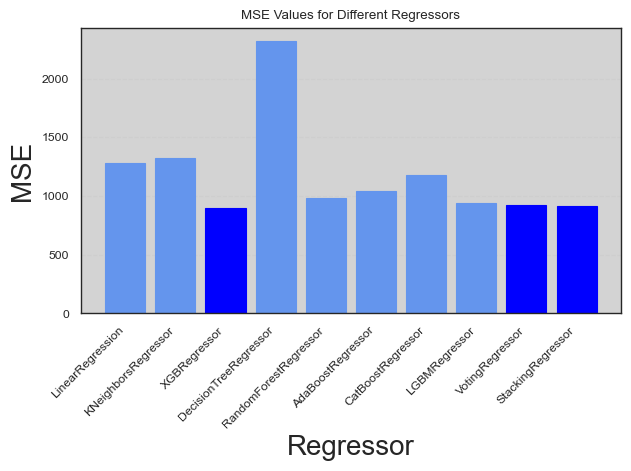

In [ ]:
# Data
regressors = [
    'LinearRegression', 'KNeighborsRegressor', 'XGBRegressor',
    'DecisionTreeRegressor', 'RandomForestRegressor', 'AdaBoostRegressor',
    'CatBoostRegressor', 'LGBMRegressor', 'VotingRegressor', 'StackingRegressor'
]
mse_values = [1284.6, 1325.3, 898.4, 2319.4, 978.9, 1039.2, 1176.6, 941.7, 920.5, 911.8]

# Create figure and axis
fig, ax = plt.subplots()

# Set background color
ax.set_facecolor('lightgray')

# Plot histogram
ax.bar(regressors, mse_values, color='cornflowerblue')

# Set title and labels
ax.set_title('MSE Values for Different Regressors')
ax.set_xlabel('Regressor')
ax.set_ylabel('MSE')

# Set grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight specific rows with blue color
highlight_indices = [2, 8, 9]
highlight_colors = ['blue' if i in highlight_indices else 'cornflowerblue' for i in range(len(regressors))]
for bar, color in zip(ax.patches, highlight_colors):
    bar.set_color(color)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout
fig.tight_layout()



# Show the plot
plt.show()


# Delete 'time'

Delete the coulmn "time" variable 

In [112]:
df_zurich = df_zurich.drop("TIME", axis = 1)
df_dijon = df_dijon.drop("TIME", axis = 1)
df_milano = df_milano.drop("TIME", axis = 1)
df_innsbruck = df_innsbruck.drop("TIME", axis = 1)
df_karlsruhe = df_karlsruhe.drop("TIME", axis = 1)

# Model Selection and Prediction Pipeline

## ML Models

ML Models training and evaluation loop.

*   Linear Regression
*   K-Nearest Neighbhor Regression (KNN)
*   Decision Tree Regression
*   Random Forest Regression
*   Extreme Gradient Boosting (XGB)
*   AdaBoost
*   CatBoost
*   Light Gradient Boosting Machine (LGBM)

## Feature Importances

Tuned models definition
*   Random Forest Regression
*   Extreme Gradient Boosting (XGB)
*   AdaBoost
*   Light Gradient Boosting Machine (LGBM)


In [ ]:
# pred_cities = ['pred_zurich', 'pred_dijon', 'pred_milano', 'pred_innsbruck', 'pred_karlsruhe']
# cities = ['Zurich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']
# regressors = [LinearRegression(),
#               KNeighborsRegressor(n_neighbors=5, weights='distance'),
#               XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06),
#               LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1),
#               DecisionTreeRegressor(),
#               RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20),
#               AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
#               CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42, verbose=0)]

# for city, df in zip(cities,dfs):
#     print()
#     cv = KFold(n_splits=5, shuffle=True, random_state=42)
#     X = df.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
#     y = df['IRRADIANCE']

#     for model in regressors:
#         scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
#         print(f'({city} {type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')





from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
import numpy as np

# List of regressors
regressors = [LinearRegression(),
              KNeighborsRegressor(n_neighbors=5, weights='distance'),
              XGBRegressor(subsample=1.0, n_jobs=-1, n_estimators=362, max_depth=7, learning_rate=0.06),
              LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1),
              DecisionTreeRegressor(),
              RandomForestRegressor(n_jobs=-1, n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=5, max_depth=20),
              AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
              CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42, verbose=0)]

cities = ['Zurich', 'Dijon', 'Milano', 'Innsbruck', 'Karlsruhe']
dfs = [df_zurich, df_dijon, df_milano, df_innsbruck, df_karlsruhe]  # Assuming `df_*` are defined elsewhere

for city, df in zip(cities, dfs):
    print(f"\nEvaluating models for {city}:")
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    X = df.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
    y = df['IRRADIANCE']

    for model in regressors:
        if hasattr(model, "fit"):  # Ensure the model has the "fit" method
            try:
                # Use cross_validate instead of cross_val_score
                results = cross_validate(model, X, y, cv=cv, scoring='neg_mean_squared_error', return_train_score=False)
                print(f'({city} {type(model).__name__}) MSE: {results["test_score"]}, Mean MSE: {np.mean(results["test_score"])}')
            except Exception as e:
                print(f"Error evaluating {type(model).__name__} for {city}: {e}")
        else:
            print(f'({city} {type(model).__name__}) is not a valid model for cross-validation')



Evaluating models for Zurich:
(Zurich LinearRegression) MSE: [-14902.51631512 -14828.96840048 -14705.06476728 -15190.13185731
 -15003.04749821], Mean MSE: -14925.945767681435
(Zurich KNeighborsRegressor) MSE: [-5620.28727292 -5659.89471681 -5401.17754281 -5605.94297646
 -5362.79772564], Mean MSE: -5530.0200469300635
Error evaluating XGBRegressor for Zurich: 'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2122
[LightGBM] [Info] Number of data points in the train set: 63110, number of used features: 13
[LightGBM] [Info] Start training from score 143.185464
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Au

light gradient boosting machine



random forest



adaboost




xtreme boost


In [128]:
xgb = XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06)
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20)
abr = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42)
lgbm = LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1)

In [129]:
X = df.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
y = df['IRRADIANCE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Random Regression Feature Importance

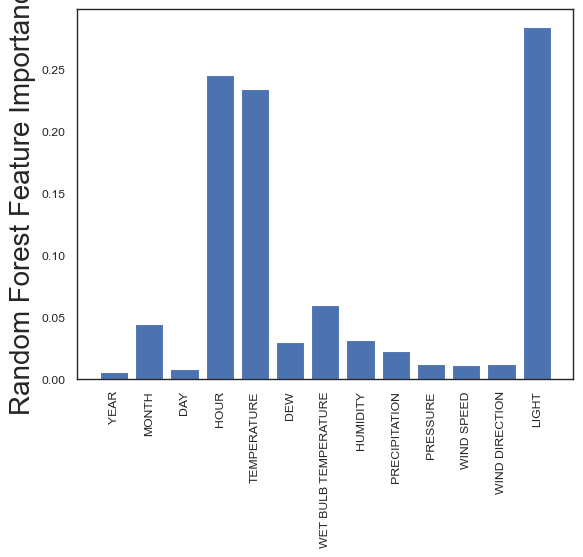

In [130]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('Random Forest Feature Importance')
plt.savefig('Random_Regression_feature_importance.pdf')
plt.show()

### Extreme Gradient Boosting (XGB) Feature Importance

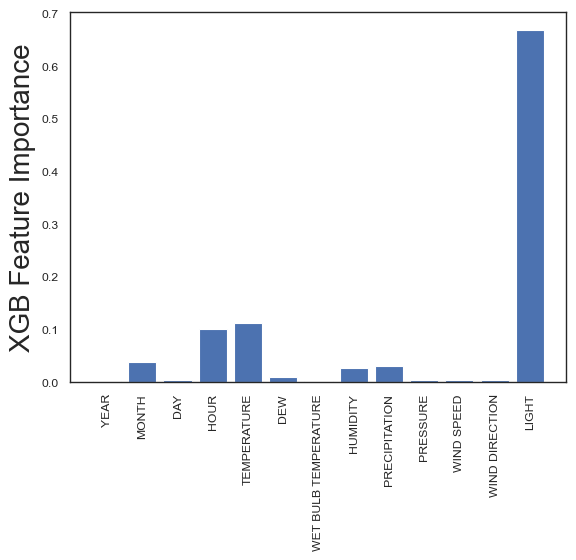

In [131]:
xgb.fit(X_train, y_train)
importances = xgb.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('XGB Feature Importance')
plt.savefig('XGB_feature_importance.pdf')
plt.show()

### AdaBoost Feature Importance

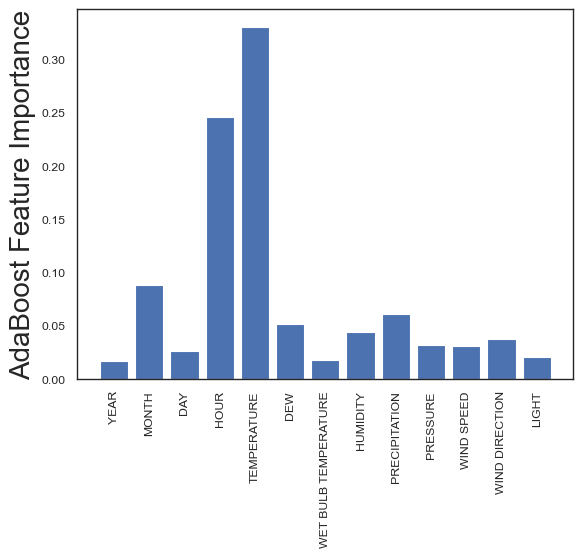

In [132]:
abr.fit(X_train, y_train)
importances = abr.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('AdaBoost Feature Importance')
plt.savefig('AdaBoost_feature_importance.pdf')
plt.show()

### Light Gradient Boosting Machine (LGBM) Feature Importance

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 63110, number of used features: 13
[LightGBM] [Info] Start training from score 138.254556


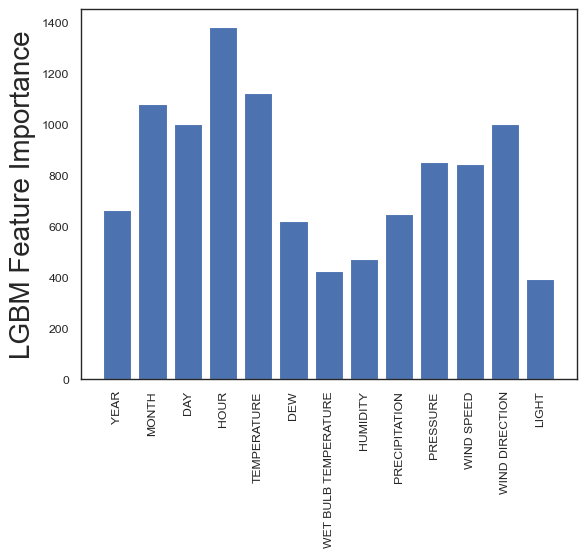

In [133]:
lgbm.fit(X_train, y_train)
importances = lgbm.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('LGBM Feature Importance')
plt.savefig('LGBM_feature_importance.pdf')
plt.show()

## Ensembling Models

The best performing models where:


*   Extreme Gradient Boosting (XGB)
*   Random Forest Regressor
*   AdaBoost Regressor
*   Light Gradient Boosting Machine (LGBM)

We decided to perform an ensemble of the first 3 and exclude LGBM due to its architecture similarity with XGB, which likely returns similar predictions. Thus, it wouldn't be fully exploited in an ensemble, but it would rather bias it.

In [229]:

rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20)
abr = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42)
elastic_net = ElasticNetCV()
estimators = [('xgb', xgb), ('rf', rf), ('abr', abr)] 

We evaluated three ensemble estimators using the above mentioned base models:

*   Voting Regressor, averaging the predictions of base estimators.
*   Stacking Regressor, with Ridge Regression as final estimator.
*   Stacking Regressor, with Elastic Net Regression as final estimator.

In [230]:
ensemble_models = [VotingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators=estimators, final_estimator=elastic_net, n_jobs=-1)
]

cv = KFold(n_splits=3, shuffle=True, random_state=42)
X = df_zurich.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET'])
y = df_zurich['IRRADIANCE']








In [ ]:
# for model in ensemble_models:
#     scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')

#     print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

## Hyperparameter Tuning

### Decision Tree Tuning

In [190]:
param_grid = {"splitter":["best","random"],
              "max_depth" : [1,3,5,7,9,11,12],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              "max_features":["auto","log2","sqrt",None],
              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

dt = DecisionTreeRegressor()
random_search_dt = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_dt.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6,
                                                                     0.7, 0.8,
                                                                     0.9],
                                        'splitter': ['best', 'random']},
                   refit=False, scoring='neg_mean_squared_error')

In [191]:
print(random_search_dt.best_score_)
random_search_dt.best_params_

-25419.704449061363


{'splitter': 'best',
 'min_weight_fraction_leaf': 0.1,
 'min_samples_leaf': 6,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': 5}

### Random Forest Tuning

In [192]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [2, 5, 10, 20],
              'max_features': [2, 5, 10, 20], 
              'n_jobs': [-1]
              }

rf = RandomForestRegressor() 
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_rf.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10, 20],
                                        'max_features': [2, 5, 10, 20],
                                        'n_estimators': [10, 50, 100, 200],
                                        'n_jobs': [-1]},
                   refit=False, scoring='neg_mean_squared_error')

In [193]:
print(random_search_rf.best_score_)
random_search_rf.best_params_

-2862.22184047047


{'n_jobs': -1, 'n_estimators': 10, 'max_features': 20, 'max_depth': 20}

### AdaBoost Tuning

In [ ]:
param_grid = {'n_estimators':[10,50,250,500],
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}

abr = AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42)
random_search_abr = RandomizedSearchCV(abr, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, refit=False, cv = cv)
random_search_abr.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(),
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1.0],
                                        'n_estimators': [10, 50, 250, 500]},
                   refit=False, scoring='neg_mean_squared_error')

In [196]:
print(random_search_abr.best_score_)
random_search_abr.best_params_

-2615.5984755841773


{'n_estimators': 500, 'learning_rate': 1.0}

## Feed-Forward Neural Network (FFNN)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step - loss: 46915.1172 - val_loss: 36407.4570
Epoch 2/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - loss: 29827.3652 - val_loss: 26310.0215
Epoch 3/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - loss: 22769.0254 - val_loss: 20707.3477
Epoch 4/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - loss: 22356.7656 - val_loss: 20270.0508
Epoch 5/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 21883.0762 - val_loss: 17457.9941
Epoch 6/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - loss: 18848.8477 - val_loss: 13970.4004
Epoch 7/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - loss: 14007.9922 - val_loss: 9095.5146
Epoch 8/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - loss: 10838.1387 - val_loss: 6682.8203
Epoch 9/100
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 9742.1221 - val_loss: 7119.2783
Epoch 10/100
1973/1973 ━━━━━━━━━━━━━━━━━━━

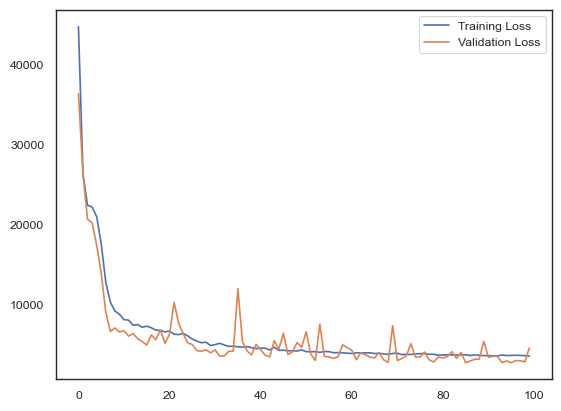

In [197]:
# Define the number of nodes in the input and output layers
input_dim = 13
output_dim = 1

# Create the model
model = Sequential()
model.add(Dense(100, input_dim=input_dim, activation='elu'))
model.add(Dense(100, activation='elu'))
model.add(Dense(100, activation='elu'))
model.add(Dense(100, activation='elu'))
model.add(Dense(100, input_dim=input_dim, activation='elu'))
model.add(Dense(output_dim))
plot_model(model, to_file='FFNN.png', show_shapes=True, show_layer_names=True)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Scaling
df_zurich_scaled = df_zurich.copy()
df_zurich_scaled[cols_to_normalize] = scaler.fit_transform(df_zurich[cols_to_normalize])

# Train the model
X_train, X_val, y_train, y_val = train_test_split(df_zurich_scaled.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET']), df_zurich['IRRADIANCE'], test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'The MSE is: {mse}')

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

## Long-Short Term Memory Neural Network (LSTM)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 43329.9961 - val_loss: 16472.7363
Epoch 2/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 15526.0176 - val_loss: 14487.1855
Epoch 3/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 10942.8281 - val_loss: 11090.8174
Epoch 4/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 9963.0479 - val_loss: 7924.4995
Epoch 5/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 7654.5278 - val_loss: 5178.9805
Epoch 6/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5139.5981 - val_loss: 4221.7397
Epoch 7/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4661.9307 - val_loss: 3388.3877
Epoch 8/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4560.4727 - val_loss: 5737.5215
Epoch 9/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4330.3887 - val_loss: 3916.7878
Epoch 10/35
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4198.1885 - v

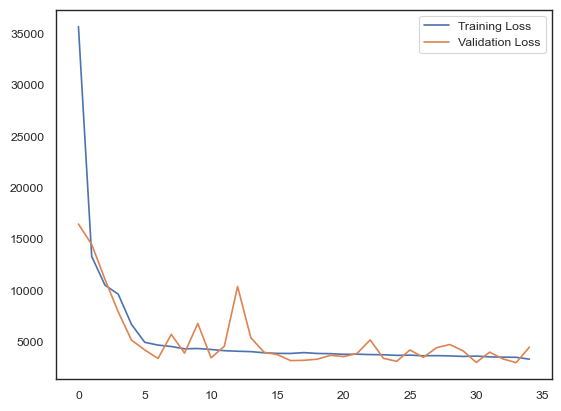

In [198]:
# Define the number of nodes in the input and output layers
input_dim = 13
output_dim = 1

# Reshape the input data for LSTM network
X_train, X_val, y_train, y_val = train_test_split(df_zurich.drop(columns=['IRRADIANCE', 'SUNRISE', 'SUNSET']), df_zurich['IRRADIANCE'], test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)
X_train, X_val = X_train.values, X_val.values
y_train, y_val = y_train.values, y_val.values
X_test, y_test = X_test.values, y_test.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Create the model
model = Sequential()
model.add(LSTM(100, input_shape=(1, input_dim), activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu'))
model.add(Dense(output_dim))
plot_model(model, to_file='LSTM.png', show_shapes=True, show_layer_names=True)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and calculate training and validation loss
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=32, verbose=1)

# Get the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'The MSE is: {mse}')

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

# "Quadrangulation" of Zurich Location



We will use the following 3 approaches:


*   Averaging the measured solar radiation in the 4 cities.
*   Ensembling the measured solar radiation in the 4 cities with different weights according to a similarity measure between Zurich climate and the other cities climates?
*   Training an model on a custom data set featuring information of all of the 4 cities.



## Averaging the measured solar radiation in the 4 cities

In [199]:
y_pred = (df_dijon['IRRADIANCE'].values + df_milano['IRRADIANCE'].values + df_karlsruhe['IRRADIANCE'].values + df_innsbruck['IRRADIANCE'].values)/4
mse = mean_squared_error(df_zurich['IRRADIANCE'].values, y_pred)
print(mse)

1979.1531860066643


## Ensembling the measured solar radiation in the 4 cities with different weights according to a similarity measure between Zurich climate and the other cities climates?

### Defining a similarity measure, i.e., correlation among features between [Dijon, Milano, Karlsruhe, Innsbruck] and Zurich.

In [200]:
# Definition of datasets for the correlation estimation
df_zurich_sim = df_zurich.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_dijon_sim = df_dijon.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_karlsruhe_sim = df_karlsruhe.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_milano_sim = df_milano.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])
df_innsbruck_sim = df_innsbruck.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'LIGHT', 'SUNSET', 'SUNRISE'])

In [201]:
# Feature-wise correlation calculation
dfs = [df_dijon_sim, df_karlsruhe_sim, df_milano_sim, df_innsbruck_sim]
corr = [[], [], [], []]

for i, df in zip(range(4), dfs):
  for feature in ['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE']:
    corr[i].append(df_zurich_sim[feature].corr(df[feature]))

In [202]:
# Mean correlations per city
dijon_mean_corr = round(np.mean(corr[0]), 3)
karlsruhe_mean_corr = round(np.mean(corr[1]), 3)
milano_mean_corr = round(np.mean(corr[2]), 3)
innsbruck_mean_corr = round(np.mean(corr[3]), 3)
correlations = [('dijon', dijon_mean_corr), ('karlsruhe', karlsruhe_mean_corr), ('milano', milano_mean_corr), ('innsbruck', innsbruck_mean_corr)]
print(correlations)

[('dijon', 0.768), ('karlsruhe', 0.792), ('milano', 0.656), ('innsbruck', 0.764)]


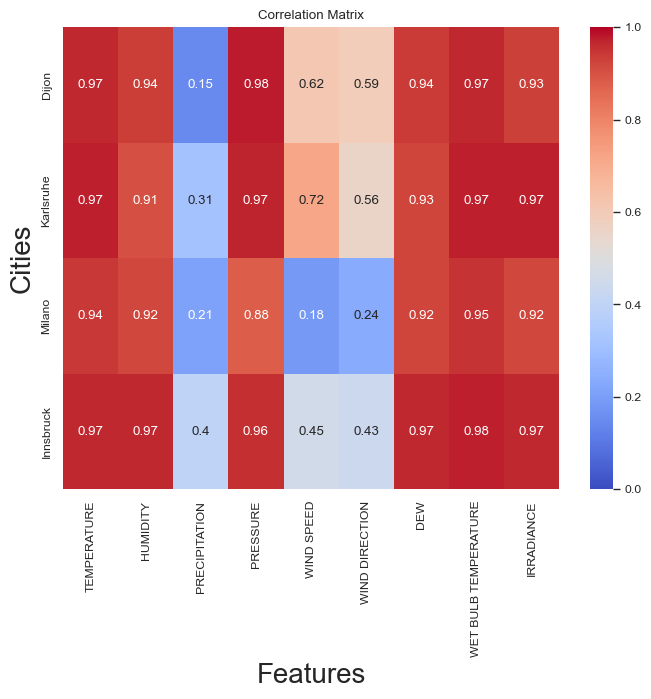

In [ ]:
#Plot of the correlations of the 4 cities with Zürich
dfs = [df_dijon_sim, df_karlsruhe_sim, df_milano_sim, df_innsbruck_sim]
cities = ['Dijon', 'Karlsruhe', 'Milano', 'Innsbruck']
correlations = []

for df, city in zip(dfs, cities):
    city_corr = []
    for feature in ['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE', 'IRRADIANCE']:
        city_corr.append(df_zurich_sim[feature].corr(df[feature]))
    correlations.append(city_corr)

correlations_df = pd.DataFrame(correlations, columns=['TEMPERATURE', 'HUMIDITY', 'PRECIPITATION', 'PRESSURE', 'WIND SPEED', 'WIND DIRECTION', 'DEW', 'WET BULB TEMPERATURE', 'IRRADIANCE'], index=cities)
plt.figure(figsize=(8, 6))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Cities')

plt.show()

### Scaling the correlations to obtain weights.

In [205]:
total = dijon_mean_corr + karlsruhe_mean_corr + milano_mean_corr + innsbruck_mean_corr
dijon_norm = dijon_mean_corr / total
karlsruhe_norm = karlsruhe_mean_corr / total
milano_norm = milano_mean_corr / total
innsbruck_norm = innsbruck_mean_corr / total
print(dijon_norm, karlsruhe_norm, milano_norm, innsbruck_norm)

0.2577181208053691 0.2657718120805369 0.22013422818791945 0.25637583892617444


### Predicting Zurich Irradiance via an ensemble of the other 4 cities radiations with the weights calculated above. 

In [206]:
y_pred = (dijon_norm * df_dijon['IRRADIANCE'].values + milano_norm * df_milano['IRRADIANCE'].values + karlsruhe_norm * df_karlsruhe['IRRADIANCE'].values + innsbruck_norm * df_innsbruck['IRRADIANCE'].values)
mse = mean_squared_error(df_zurich['IRRADIANCE'].values, y_pred)
print(mse)

1888.75399430857


### Which of the 4 neighboring locations has the most similar climate to Zurich? Does it also share the highest correlation in terms of solar radiation over time?

Karlsruhe has the most similar climate to zurich, with a mean correlation of the weather parameters of: 0.792. 
And, indeed, it shares also the highest correlation in terms of solar radiation over time, i.e., 0.974.

In [207]:
irr_corr = []
for df in dfs:
  irr_corr.append(df_zurich_sim['IRRADIANCE'].corr(df['IRRADIANCE']))
print(irr_corr)

[0.9311058817068877, 0.9740924224256111, 0.9213114082055419, 0.9667764423839087]


## Training an model on a custom data set featuring information of all of the 4 cities.

In [208]:
# Definition of the features for the custom dataset
df_zurich_custom = df_zurich[['YEAR', 'MONTH', 'DAY', 'HOUR', 'IRRADIANCE']]
df_dijon_custom = df_dijon.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_dijon")
df_karlsruhe_custom = df_karlsruhe.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_karlsruhe")
df_milano_custom = df_milano.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_milano")
df_innsbruck_custom = df_innsbruck.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'SUNSET', 'SUNRISE']).rename(columns=lambda x: x + "_innsbruck")

In [209]:
# Concatentation of the 4 datasets
df_custom = pd.concat([df_zurich_custom, df_dijon_custom, df_karlsruhe_custom, df_milano_custom, df_innsbruck_custom], axis=1, sort=False)

In [210]:
np.shape(df_custom)

(78888, 45)

### ML Models

ML Models training and evaluation loop on the custom data set.

In [232]:
regressors = [LinearRegression(),
              KNeighborsRegressor(n_neighbors=5, weights='distance'),
            #   XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06),
              LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1),
              DecisionTreeRegressor(),
              RandomForestRegressor(n_jobs = -1, n_estimators = 510, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 19),
              AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
              CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42, verbose=0)]

X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for model in regressors:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

(LinearRegression) MSE: [-1251.80243881 -1291.79037146 -1302.02988366], Mean MSE: -1281.874231313749
(KNeighborsRegressor) MSE: [-1291.06946677 -1315.62249816 -1369.12477007], Mean MSE: -1325.272244999851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9253
[LightGBM] [Info] Number of data points in the train set: 52592, number of used features: 44
[LightGBM] [Info] Start training from score 142.987686
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

In [233]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
import numpy as np

# Define the selected regressors
regressors = [
    AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42),
    RandomForestRegressor(n_jobs=-1, n_estimators=510, min_samples_split=2, min_samples_leaf=1, max_features=5, max_depth=19),
    LGBMRegressor(max_depth=15, learning_rate=0.05, n_estimators=350, n_jobs=-1)
]

# Define cross-validation and data
X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate each model
for model in regressors:
    mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    # Output MSE and R^2
    print(f'({type(model).__name__}) MSE: {mse_scores}, Mean MSE: {np.mean(mse_scores)}')
    print(f'({type(model).__name__}) R^2: {r2_scores}, Mean R^2: {np.mean(r2_scores)}\n')


(AdaBoostRegressor) MSE: [ -998.04297755 -1037.68461333 -1068.14951377], Mean MSE: -1034.625701550299
(AdaBoostRegressor) R^2: [0.97838721 0.97759662 0.97731375], Mean R^2: 0.9777658596197178

(RandomForestRegressor) MSE: [ -960.89490143  -998.24280602 -1004.05212484], Mean MSE: -987.7299440951069
(RandomForestRegressor) R^2: [0.97926425 0.97851645 0.97879001], Mean R^2: 0.9788569028143795

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9253
[LightGBM] [Info] Number of data points in the train set: 52592, number of used features: 44
[LightGBM] [Info] Start training from score 142.987686
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wi

### Feature Importance

In [234]:
X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Random Forest Feature Importance

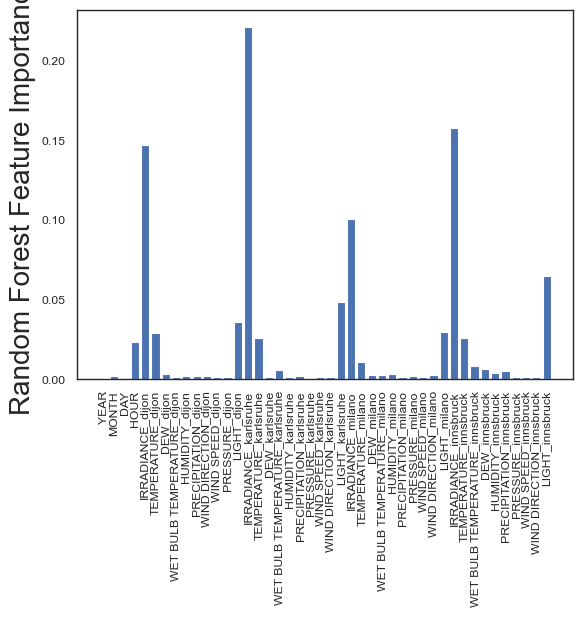

In [235]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('Random Forest Feature Importance')
plt.show()

#### Extreme Gradient Boosting (XGB) Feature Importance

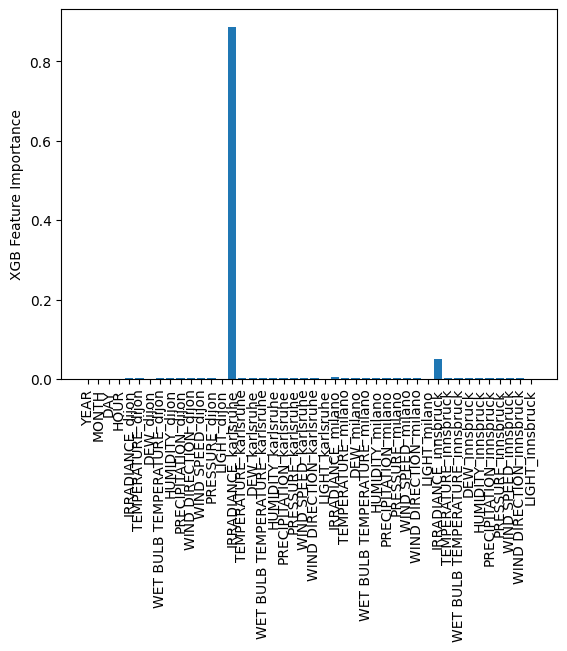

In [ ]:
xgb.fit(X_train, y_train)
importances = xgb.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('XGB Feature Importance')
plt.show()

#### Light Gradient Boosting Machine (LGBM) Feature Importance

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9254
[LightGBM] [Info] Number of data points in the train set: 63110, number of used features: 44
[LightGBM] [Info] Start training from score 143.185464


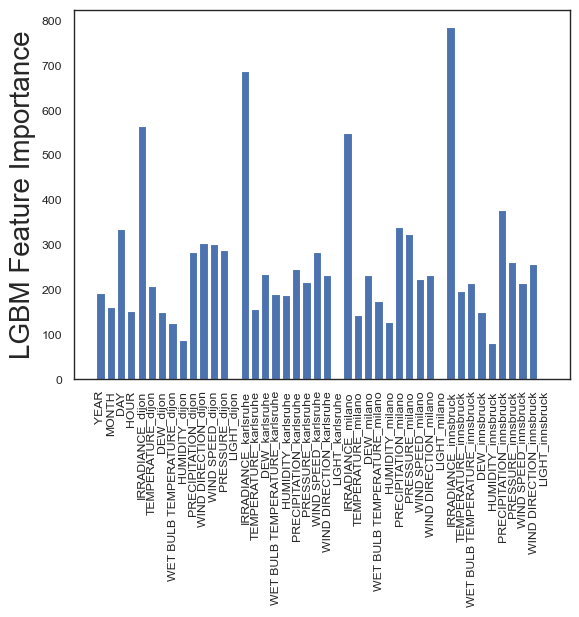

In [236]:
lgbm.fit(X_train, y_train)
importances = lgbm.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('LGBM Feature Importance')
plt.show()

### Ensembling Methods

Ensembling methods for the custom data set.

In [ ]:
xgb = XGBRegressor(subsample = 1.0, n_jobs = -1, n_estimators = 362, max_depth = 7, learning_rate = 0.06)
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 5, max_depth = 20)
abr = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250, learning_rate=1.0, random_state=42)
elastic_net = ElasticNetCV()
estimators = [('rf', rf), ('abr', abr)] 

ensemble_models = [VotingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, elastic_net, n_jobs=-1)]

X = df_custom.drop(columns=['IRRADIANCE'])
y = df_custom['IRRADIANCE']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for model in ensemble_models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'({type(model).__name__}) MSE: {scores}, Mean MSE: {np.mean(scores)}')

(VotingRegressor) MSE: [-939.07037764 -979.3301489  -995.13150078], Mean MSE: -971.1773424393277
(StackingRegressor) MSE: [ -945.1431522   -981.38989267 -1014.41218421], Mean MSE: -980.3150763585519
(StackingRegressor) MSE: [ -940.3115899   -983.88241938 -1001.91524078], Mean MSE: -975.3697500209918


In [240]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Define cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop through ensemble models
for model in ensemble_models:
    # Compute R² score
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mean_r2 = np.mean(r2_scores)
    
    # Convert R² to accuracy percentage
    accuracy_percentage = mean_r2 * 100
    
    print(f'({type(model).__name__}) R² Scores: {r2_scores}, Mean R²: {mean_r2}, Accuracy: {accuracy_percentage:.2f}%')


(VotingRegressor) R² Scores: [0.97960107 0.9788663  0.97896776], Mean R²: 0.9791450422921417, Accuracy: 97.91%
(StackingRegressor) R² Scores: [0.97957955 0.97880422 0.97868323], Mean R²: 0.979022333533142, Accuracy: 97.90%
(StackingRegressor) R² Scores: [0.97963195 0.978684   0.97873467], Mean R²: 0.9790168758081467, Accuracy: 97.90%


In [241]:
import joblib

# Loop through ensemble models
for model in ensemble_models:
    # Save the model
    model_filename = f"{type(model).__name__}_model.joblib"
    joblib.dump(model, model_filename)
    print(f'Model saved as {model_filename}')


Model saved as VotingRegressor_model.joblib
Model saved as StackingRegressor_model.joblib
Model saved as StackingRegressor_model.joblib
